# Фролов Владимир
**Stepik User ID: 541150734**

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets
import os
import random
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk
import string
import itertools

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
seed = 42
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.cuda.empty_cache()
!nvidia-smi

cuda
Sat Jun 10 20:36:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    13W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [ ]:
# Загрузим датасет
dataset = load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.

In [ ]:
snt = [x.lower() for x in sent_tokenize(dataset['train']['text'][0], language='english')]
for i in range(len(snt)):
    if len(word_tokenize(snt[i])) < 32:
        print(f"{snt[i]} Количество слов в предложении: {len(word_tokenize(snt[i]))}")
print("\n Сравним: \n")
snt

i rented i am curious-yellow from my video store because of all the controversy that surrounded it when it was first released in 1967. Количество слов в предложении: 25
really, the sex and nudity scenes are few and far between, even then it's not shot like some cheaply made porno. Количество слов в предложении: 25
while my countrymen mind find it shocking, in reality sex and nudity are a major staple in swedish cinema. Количество слов в предложении: 21
i am curious-yellow is a good film for anyone wanting to study the meat and potatoes (no pun intended) of swedish cinema. Количество слов в предложении: 25
but really, this film doesn't have much of a plot. Количество слов в предложении: 13

 Сравним: 



['i rented i am curious-yellow from my video store because of all the controversy that surrounded it when it was first released in 1967.',
 'i also heard that at first it was seized by u.s. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" i really had to see this for myself.<br /><br />the plot is centered around a young swedish drama student named lena who wants to learn everything she can about life.',
 'in particular she wants to focus her attentions to making some sort of documentary on what the average swede thought about certain political issues such as the vietnam war and race issues in the united states.',
 'in between asking politicians and ordinary denizens of stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />what kills me about i am curious-yellow is that 40 years ago, this was considered pornographic.',
 "really, the sex and nudity scenes are few an

In [ ]:
sentences = set()
word_threshold = 32

for example in tqdm(dataset['train']['text']):
    for sentence in sent_tokenize(example.lower(), language='english'):
        if len(word_tokenize(sentence)) < word_threshold:
            sentences.add(sentence)

  0%|          | 0/25000 [00:00<?, ?it/s]

In [ ]:
print("Всего предложений:", len(sentences))

Всего предложений: 188848


In [ ]:
sentences = list(sentences)
type(sentences)

list

In [ ]:
sentences[:10]

["i mean if a slasher hasn't got any sex or gore then what's the point?",
 'and she winds up boffing a con she brought in for questioning!',
 "the movie spends too much time focusing on the love affair between winston and julia, which frankly isn't what orwell was writing about.",
 'kitschy and campy (though surprisingly faithful to the real events), this romantic piece is irresistible.',
 'i did like the flashbacks.',
 'but still, you gotta love this stuff!',
 "a curiosity at best, far from joshua logan's usual caliber of work.",
 "nor that the cars and clothes in the background plates from 1934 did not seem match up too 1950s' standards.",
 "this doesn't last too long after her release and she's back to her old ways.",
 'there are a few quite engrossing scenes in there but they are necessary and help you to understand the situation much better.']

Посчитаем для каждого слова его встречаемость.

In [ ]:
words = Counter()

for sentence in tqdm(sentences):
    for word in word_tokenize(sentence):
        words[word] += 1
len(words)

  0%|          | 0/188848 [00:00<?, ?it/s]

67996

In [ ]:
words = dict(sorted(words.items(), key=lambda item: item[1], reverse=True))
dict(itertools.islice(words.items(), 10))

{'.': 164269,
 'the': 148416,
 ',': 111871,
 'a': 73761,
 'and': 71924,
 'of': 61439,
 'to': 59463,
 'is': 56404,
 'it': 50486,
 'i': 47378}

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [ ]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

# Наполнение словаря
for word in tqdm(words.keys()):
    vocab.add(word)
    if len(vocab) == vocab_size + 4:
        break

  0%|          | 0/67996 [00:00<?, ?it/s]

In [ ]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [ ]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


In [ ]:
vocab = list(vocab)
type(vocab)

list

In [ ]:
vocab[:10]

['folklore',
 'latching',
 'pujari',
 'second-hand',
 'cryofreezing',
 "'90",
 'stitzer',
 'disgraceful',
 'milestones',
 'indulges']

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Увеличим нашу выборку и уберём ограничение на количество слов в нашем словаре.

In [ ]:
sentences = set(sentences)
type(sentences)

set

In [ ]:
for example in tqdm(dataset['unsupervised']['text']):
    for sentence in sent_tokenize(example.lower(), language='english'):
        if len(word_tokenize(sentence)) < word_threshold:
            sentences.add(sentence)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
print("Всего предложений:", len(sentences))

Всего предложений: 554041


In [ ]:
sentences = list(sentences)
type(sentences)

list

In [ ]:
sentences[:10]

["it's not so much masters of science fiction as masters, if even that, of left wing propaganda.",
 "for the fans of this type of films, i'd highly recommend men behind the sun, audition and/or ichi the killer instead!",
 'that would have been best under the circumstances.',
 'the sub-plots tried to grab your attention, but in reality only increased your eagerness for the film to grind to a blundering halt.',
 'and she winds up boffing a con she brought in for questioning!',
 'too bad maybe next time.',
 'ignore all other commentaries!!',
 'in fact, his appearance in the opening scene is probably the most satisfying moment of this movie.',
 '"tears of the black tiger" is a stylistic hybrid that brings together the cinematic excesses of douglas sirk and sergio leone, with a smattering of quentin tarrentino.',
 '<br /><br />i enjoyed the naked shakiness of this movie.']

In [ ]:
words = Counter()

for sentence in tqdm(sentences):
    for word in word_tokenize(sentence):
        words[word] += 1
len(words)

  0%|          | 0/554041 [00:00<?, ?it/s]

122648

In [ ]:
words = dict(sorted(words.items(), key=lambda item: item[1], reverse=True))
dict(itertools.islice(words.items(), 10))

{'.': 482915,
 'the': 440847,
 ',': 333198,
 'a': 219001,
 'and': 213773,
 'of': 182926,
 'to': 176265,
 'is': 166570,
 'it': 147519,
 'i': 137627}

In [ ]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

# Наполнение словаря
for word in tqdm(words.keys()):
    vocab.add(word)

  0%|          | 0/122648 [00:00<?, ?it/s]

In [ ]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab

In [ ]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 122652


In [ ]:
vocab = list(vocab)
type(vocab)

list

In [ ]:
vocab[:10]

['folklore',
 'latching',
 'toke',
 'fruitcakes',
 '20yrs',
 'guerre',
 'cryofreezing',
 'codpieces',
 'staked',
 'gallops']

### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [ ]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [ ]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(self.data[idx])
        ]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [ ]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [ ]:
seed_torch(seed)
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [ ]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [ ]:
clip = 2

def train_model(model, train_loader, val_loader, criterion, optimizer, clip, scheduler, epochs):
    since = time()
    train_losses = []
    train_perplexities = []
    val_losses = []
    val_perplexities = []
    best_score = float('inf')

    for epoch in range(epochs):
        train_epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f"Training epoch {epoch + 1}"):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            # Gradien clipping (решение проблемы взрыва градиентов), clip - максимальная норма вектора
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
            optimizer.step()
            train_epoch_losses.append(loss.item())

        train_losses.append(sum(train_epoch_losses) / len(train_epoch_losses))
        train_perplexities.append(evaluate(model, criterion, train_loader))
        print(f"Train loss: {train_losses[epoch]}")
        print(f"Train perplexity: {train_perplexities[epoch]}")

        model.eval()
        with torch.no_grad():
            val_epoch_losses = []
            for batch in tqdm(val_loader):
                logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
                loss = criterion(logits, batch['target_ids'].flatten())
                val_epoch_losses.append(loss.item())

        val_losses.append(sum(val_epoch_losses) / len(val_epoch_losses))
        val_perplexities.append(evaluate(model, criterion, val_loader))
        print(f"Val loss: {val_losses[epoch]}")
        print(f"Val perplexity: {val_perplexities[epoch]}")

        if val_perplexities[epoch] < best_score:
            best_score = val_perplexities[epoch]
            print(f"Best perplexity: {val_perplexities[epoch]}")

        scheduler.step()
        print(f"Time: {(time() - since)}")

    plt.subplots(figsize=(23, 9))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(1, len(train_losses) + 1), train_losses, color='b', label="train loss")
    plt.plot(np.arange(1, len(val_losses) + 1), val_losses, label="val losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    best_ep = np.argmin(val_losses) + 1
    plt.axvline(best_ep, color='r', label="best epoch")
    plt.legend(loc='upper right')
    plt.title(f"Losses {model}")

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, len(train_perplexities) + 1), train_perplexities, color='b', label="train perplexity")
    plt.plot(np.arange(1, len(val_perplexities) + 1), val_perplexities, label="val perplexity")
    best_ep = np.argmin(val_perplexities) + 1
    plt.axvline(best_ep, color='r', label="best epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.legend(loc='upper right')
    plt.title(f"Perplexities {model}")

    plt.show()

    t = time() - since

    return train_losses, val_losses, train_perplexities, val_perplexities, t

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [ ]:
class GRULanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch) # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings) # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output))) # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output)) # [batch_size, seq_len, vocab_size]

        return projection

In [ ]:
seed_torch(seed)
model_gru = GRULanguageModel(hidden_dim=256, vocab_size=len(vocab), num_layers=2).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_gru.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

Training epoch 1:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 5.610571640411945
Train perplexity: 152.36968822947605


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 5.031780182830686
Val perplexity: 153.87250715219554
Best perplexity: 153.87250715219554
Time: 271.09482049942017


Training epoch 2:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.9332323671901355
Train perplexity: 112.05412630344426


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.7404192954221065
Val perplexity: 114.98263933342001
Best perplexity: 114.98263933342001
Time: 544.3184542655945


Training epoch 3:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.707132303139399
Train perplexity: 93.56161202827215


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.5775698122939446
Val perplexity: 97.69464436973014
Best perplexity: 97.69464436973014
Time: 815.9358787536621


Training epoch 4:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.518761666319715
Train perplexity: 83.44682041978957


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.477038608333928
Val perplexity: 88.34227222349585
Best perplexity: 88.34227222349585
Time: 1087.3158469200134


Training epoch 5:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.435215716236835
Train perplexity: 77.73832234601466


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.417556162449079
Val perplexity: 83.23640148814131
Best perplexity: 83.23640148814131
Time: 1358.215965270996


Training epoch 6:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.363593655456233
Train perplexity: 73.22055553723754


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.368624027505477
Val perplexity: 79.25958237996916
Best perplexity: 79.25958237996916
Time: 1629.3755881786346


Training epoch 7:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.280081187941884
Train perplexity: 69.5273890676991


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.325127095064819
Val perplexity: 75.88675467948603
Best perplexity: 75.88675467948603
Time: 1900.4132928848267


Training epoch 8:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.242957403657802
Train perplexity: 67.30475364833642


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.2991205224499796
Val perplexity: 73.93702643996654
Best perplexity: 73.93702643996654
Time: 2175.064418077469


Training epoch 9:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.209620528863105
Train perplexity: 65.35240498283574


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.2760393054181645
Val perplexity: 72.24932849439502
Best perplexity: 72.24932849439502
Time: 2448.007903575897


Training epoch 10:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.170395328067905
Train perplexity: 63.06109111052666


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.246006180923483
Val perplexity: 70.10970809336924
Best perplexity: 70.10970809336924
Time: 2729.4256026744843


<ipython-input-30-8aa5311c88fd>:50: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


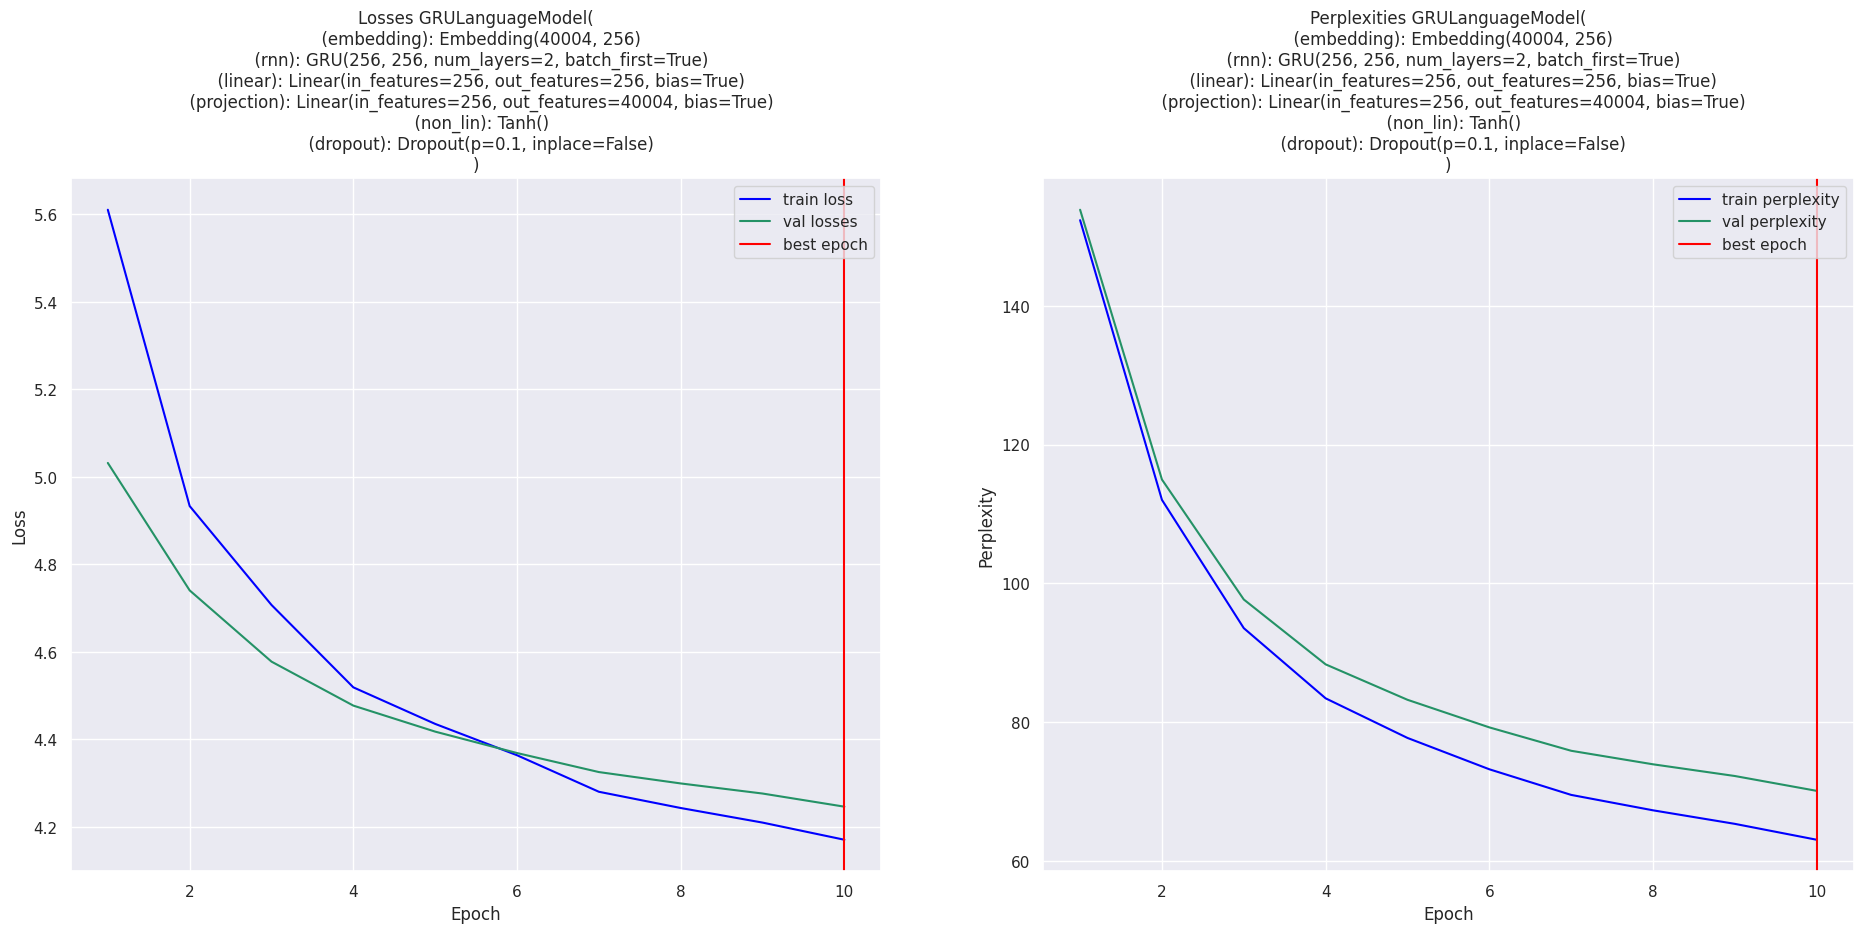

In [ ]:
epochs = 10
gru_train_losses, gru_val_losses, gru_train_perp, gru_val_perp, gru_time = train_model(
    model_gru, train_dataloader, eval_dataloader, criterion, optimizer, clip, scheduler, epochs
)

In [ ]:
gru_test_perp = evaluate(model_gru, criterion, test_dataloader)
print(f"Test perplexity: {gru_test_perp}")

Test perplexity: 70.01296412977099


In [ ]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 32) -> str:
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(word, word2ind['<unk>']) for word in word_tokenize(starting_seq)]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_word_distribution = model(input_ids)[-1]
            next_word = next_word_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

            if next_word.item() == word2ind['<eos>']:
                break

    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words

In [ ]:
print(generate_sequence(model_gru, starting_seq="don't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very"))
print("\nOriginal:", "\ndon't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very badly.")

<bos> do n't get me wrong , george c. scott was terrific as scrooge , but the rest of the cast fails so very well . <eos>

Original: 
don't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very badly.


Что-то так себе генерирует, может быть стоит попробовать ещё:

In [ ]:
print(generate_sequence(model_gru, starting_seq="saw this movie in my english class this afternoon and was surprised by how bad this version"))
print("\nOriginal:", "saw this movie in my english class this afternoon and was surprised by how bad this version was.")

<bos> saw this movie in my english class this afternoon and was surprised by how bad this version was . <eos>

Original: saw this movie in my english class this afternoon and was surprised by how bad this version was.


Посмотрим результат на тесте. Будем предсказывать последнее слово (токен).

In [ ]:
test_sentences = set()
for example in tqdm(dataset['test']['text']):
    for sentence in sent_tokenize(example.lower(), language='english'):
        if len(word_tokenize(sentence)) < word_threshold:
            test_sentences.add(sentence)

test_sentences = list(test_sentences)
print(f"Всего предложений: {len(test_sentences)}", "\n")
test_sentences[:10]

  0%|          | 0/25000 [00:00<?, ?it/s]

Всего предложений: 185411 



['it was about a woman dissatisfied with her culture who tries everything else and then goes back to her roots.',
 'it was not without its problems, but those problems had nothing to do with the time period.',
 'i rented this film from blockbust because of the cover and title!',
 'this is one of those movies that actually have the power to make you a better person, like de sica\'s "bicycle thieves".',
 'whyyyyyyyyyyyyyyyy????!!!',
 'his acting is mature, confident, and laced with the right amount of humour.',
 'not sure if this is just a lousy movie or if it was intended to be a mockery of a "b" western.',
 'watching barricade is like eating a badly cooked meal.',
 'not got enough money to hire a professional dancer?',
 'the cover case and the premise that write there is so promising.']

In [ ]:
print(generate_sequence(model_gru, starting_seq='every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch'))
print("\nOriginal:", '\nevery review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch it')

<bos> every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch . <eos>

Original: 
every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch it


In [ ]:
print(generate_sequence(model_gru, starting_seq="if you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main"))
print("\nOriginal:", "\nif you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main characters.")

<bos> if you 've read this far , you must really want to know ... a group of remarkably unscientific scientists comprise the main character . <eos>

Original: 
if you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main characters.


В целом модель завершает фразы не самыми курьёзными по смыслу словами, т.е. данные слова могли бы там присутствовать. Однако в оригинале чаще встречаются либо другие формы данного слова, либо совершенно другие слова.

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [ ]:
class LSTMLanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_layers: int, non_lin,
                 layer_norm=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.layer_norm = layer_norm(hidden_dim)

        self.non_lin = non_lin()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:

        if self.layer_norm != None:
            embeddings = self.embedding(input_batch)    # [batch_size, seq_len, hidden_dim]
            output, _ = self.rnn(embeddings)    # [batch_size, seq_len, hidden_dim]
            output = self.dropout(self.linear(self.non_lin(self.layer_norm(output))))    # [batch_size, seq_len, hidden_dim]
            projection = self.projection(self.non_lin(self.layer_norm(output)))    # [batch_size, seq_len, vocab_size]
        else:
            embeddings = self.embedding(input_batch)    # [batch_size, seq_len, hidden_dim]
            output, _ = self.rnn(embeddings)    # [batch_size, seq_len, hidden_dim]
            output = self.dropout(self.linear(self.non_lin(output)))    # [batch_size, seq_len, hidden_dim]
            projection = self.projection(self.non_lin(output))    # [batch_size, seq_len, vocab_size]

        return projection

In [ ]:
seed_torch(seed)
model_lstm = LSTMLanguageModel(hidden_dim=256, vocab_size=len(vocab), num_layers=2,
                               non_lin=nn.Tanh).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_lstm.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

Training epoch 1:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 5.917712563281338
Train perplexity: 181.0370635857126


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 5.200015813031494
Val perplexity: 182.03249106885295
Best perplexity: 182.03249106885295
Time: 273.8669285774231


Training epoch 2:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 5.049526365604772
Train perplexity: 123.91965350894783


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.834778922683178
Val perplexity: 126.34883533260687
Best perplexity: 126.34883533260687
Time: 550.2665891647339


Training epoch 3:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.7905862825992855
Train perplexity: 102.24674469691833


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.657367848445406
Val perplexity: 105.80525475271995
Best perplexity: 105.80525475271995
Time: 825.3827772140503


Training epoch 4:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.604938693615868
Train perplexity: 91.50290399562697


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.557624020227572
Val perplexity: 95.75300666374889
Best perplexity: 95.75300666374889
Time: 1101.1339201927185


Training epoch 5:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.524275314999676
Train perplexity: 85.22474478544773


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.4961330083004505
Val perplexity: 90.03998119075123
Best perplexity: 90.03998119075123
Time: 1383.3001186847687


Training epoch 6:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.454916274113538
Train perplexity: 80.18348763939892


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.444456026159974
Val perplexity: 85.5024036986395
Best perplexity: 85.5024036986395
Time: 1671.248541355133


Training epoch 7:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.376667065503333
Train perplexity: 76.36782020032658


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.402623866631733
Val perplexity: 81.998030525559
Best perplexity: 81.998030525559
Time: 1964.2738208770752


Training epoch 8:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.3427490901381764
Train perplexity: 74.1551046153431


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.378501853968716
Val perplexity: 80.0428640629218
Best perplexity: 80.0428640629218
Time: 2263.3715908527374


Training epoch 9:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.312469776760815
Train perplexity: 72.11817973473636


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.355786912809543
Val perplexity: 78.24368713606341
Best perplexity: 78.24368713606341
Time: 2544.3580343723297


Training epoch 10:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.276003125963526
Train perplexity: 70.11516671499693


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.331985367669
Val perplexity: 76.40289095746792
Best perplexity: 76.40289095746792
Time: 2819.213877439499


<ipython-input-30-8aa5311c88fd>:50: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


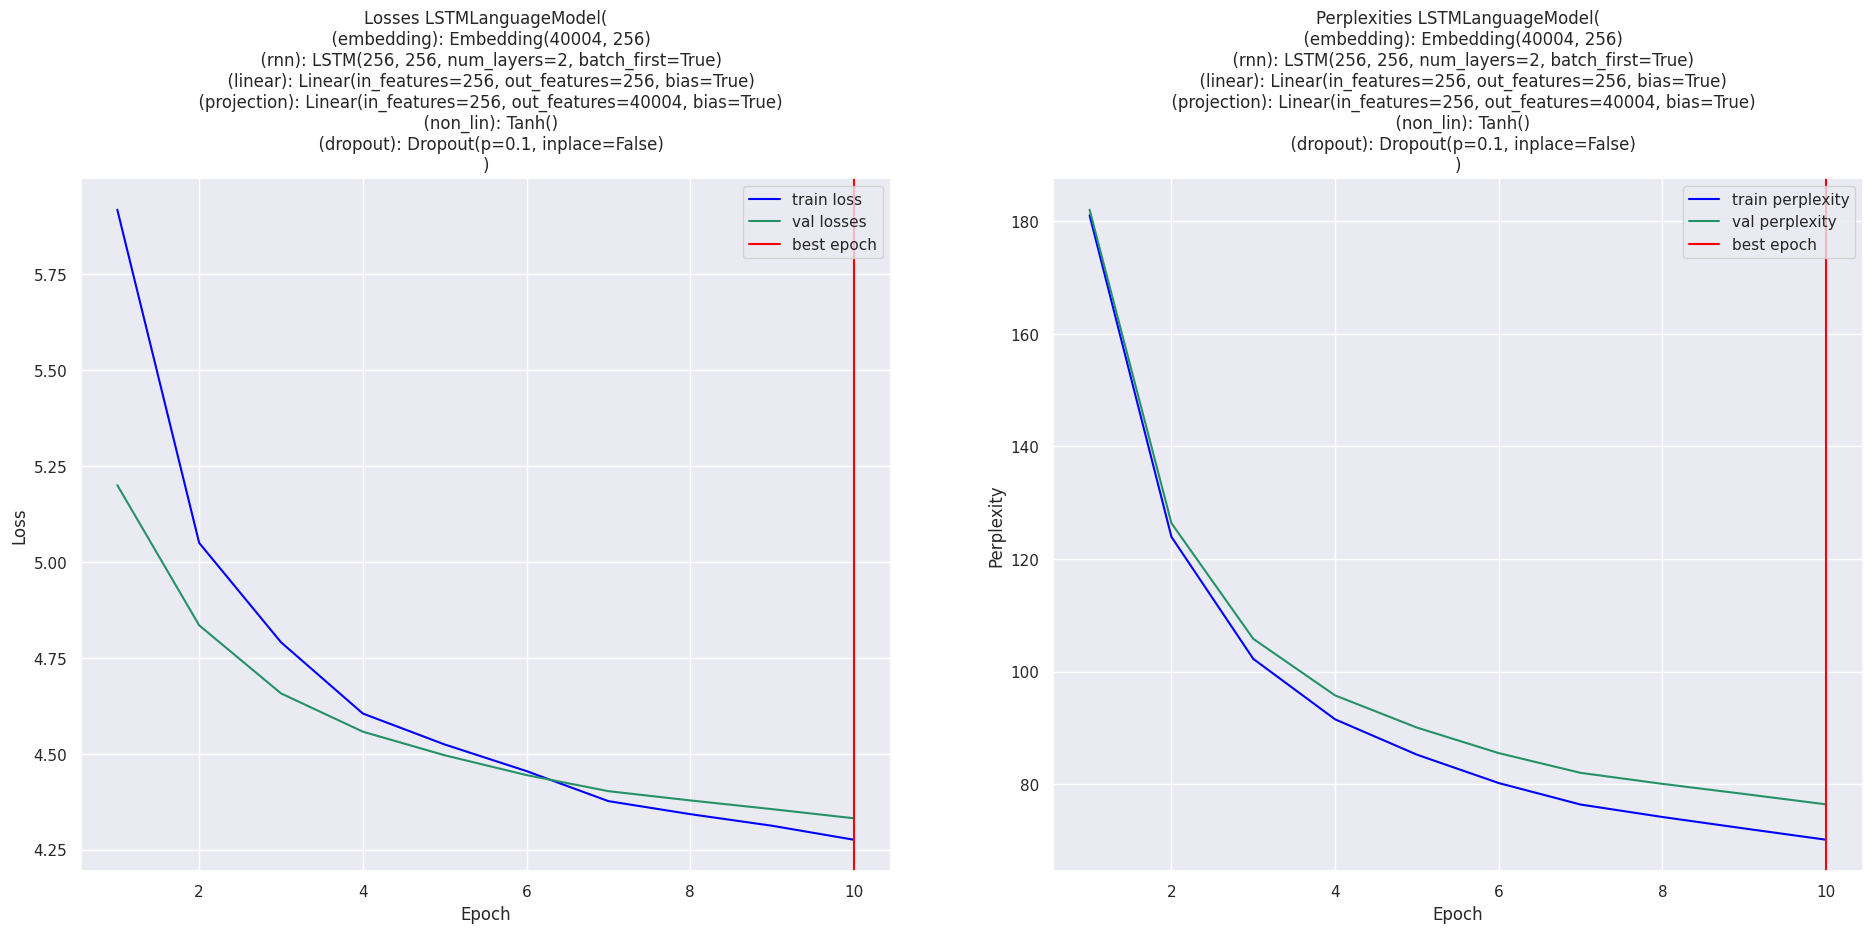

In [ ]:
epochs = 10
lstm_train_losses, lstm_val_losses, lstm_train_perp, lstm_val_perp, lstm_time = train_model(
    model_lstm, train_dataloader, eval_dataloader, criterion, optimizer, clip, scheduler, epochs
)

In [ ]:
lstm_test_perp = evaluate(model_lstm, criterion, test_dataloader)
print(f"Test perplexity: {lstm_test_perp}")

Test perplexity: 76.24361047512147


In [ ]:
print(generate_sequence(model_lstm, starting_seq="don't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very"))
print("\nOriginal:", "\ndon't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very badly.")

<bos> do n't get me wrong , george c. scott was terrific as scrooge , but the rest of the cast fails so very well . <eos>

Original: 
don't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very badly.


In [ ]:
print(generate_sequence(model_lstm, starting_seq="saw this movie in my english class this afternoon and was surprised by how bad this version"))
print("\nOriginal:", "\nsaw this movie in my english class this afternoon and was surprised by how bad this version was.")

<bos> saw this movie in my english class this afternoon and was surprised by how bad this version was . <eos>

Original: 
saw this movie in my english class this afternoon and was surprised by how bad this version was.


In [ ]:
print(generate_sequence(model_lstm, starting_seq='every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch'))
print("\nOriginal:", '\nevery review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch it')

<bos> every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch . <eos>

Original: 
every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch it


In [ ]:
print(generate_sequence(model_lstm, starting_seq="if you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main"))
print("\nOriginal:", "\nif you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main characters.")

<bos> if you 've read this far , you must really want to know ... a group of remarkably unscientific scientists comprise the main character . <eos>

Original: 
if you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main characters.


Модель LSTM не демонстрирует улучшений качества.

### Exp #3. GRU + LayerNorm.

In [ ]:
class GRULanguageModel2(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.layer_norm = nn.LayerNorm(hidden_dim)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch) # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings) # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(self.layer_norm(output)))) # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(self.layer_norm(output))) # [batch_size, seq_len, vocab_size]

        return projection

In [ ]:
seed_torch(seed)
model_gru2 = GRULanguageModel2(hidden_dim=256, vocab_size=len(vocab), num_layers=2).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_gru2.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

Training epoch 1:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 5.189576760275095
Train perplexity: 106.78475711186188


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.689033847514207
Val perplexity: 109.24494163906024
Best perplexity: 109.24494163906024
Time: 275.63816380500793


Training epoch 2:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.6457474459842745
Train perplexity: 81.13686745213211


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.442355283230624
Val perplexity: 85.3375529157437
Best perplexity: 85.3375529157437
Time: 547.7900381088257


Training epoch 3:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.433713418765153
Train perplexity: 68.61011476379446


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.301507779253208
Val perplexity: 74.10911656718267
Best perplexity: 74.10911656718267
Time: 819.6318893432617


Training epoch 4:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.221834873971447
Train perplexity: 59.816061166865055


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.188052418109201
Val perplexity: 66.15243671903119
Best perplexity: 66.15243671903119
Time: 1091.9702973365784


Training epoch 5:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.132645743666414
Train perplexity: 55.297345360894006


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.127984991887721
Val perplexity: 62.29285749833435
Best perplexity: 62.29285749833435
Time: 1363.6174449920654


Training epoch 6:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.0557734088106345
Train perplexity: 51.637975700824164


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.077373939801038
Val perplexity: 59.21683233927905
Best perplexity: 59.21683233927905
Time: 1635.6969661712646


Training epoch 7:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 3.9527080365906926
Train perplexity: 47.97655533088859


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.020061382756324
Val perplexity: 55.91823210884239
Best perplexity: 55.91823210884239
Time: 1908.7431995868683


Training epoch 8:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 3.9079746358178613
Train perplexity: 46.11316248080571


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.9917601046523425
Val perplexity: 54.359539647089434
Best perplexity: 54.359539647089434
Time: 2182.2358586788177


Training epoch 9:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 3.8695120970946464
Train perplexity: 44.50116032528534


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.9669936097411282
Val perplexity: 53.03165652370711
Best perplexity: 53.03165652370711
Time: 2455.9342856407166


Training epoch 10:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 3.8188321330000243
Train perplexity: 42.57380745715756


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.9328064766679676
Val perplexity: 51.2510645176337
Best perplexity: 51.2510645176337
Time: 2729.0904562473297


<ipython-input-30-8aa5311c88fd>:50: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


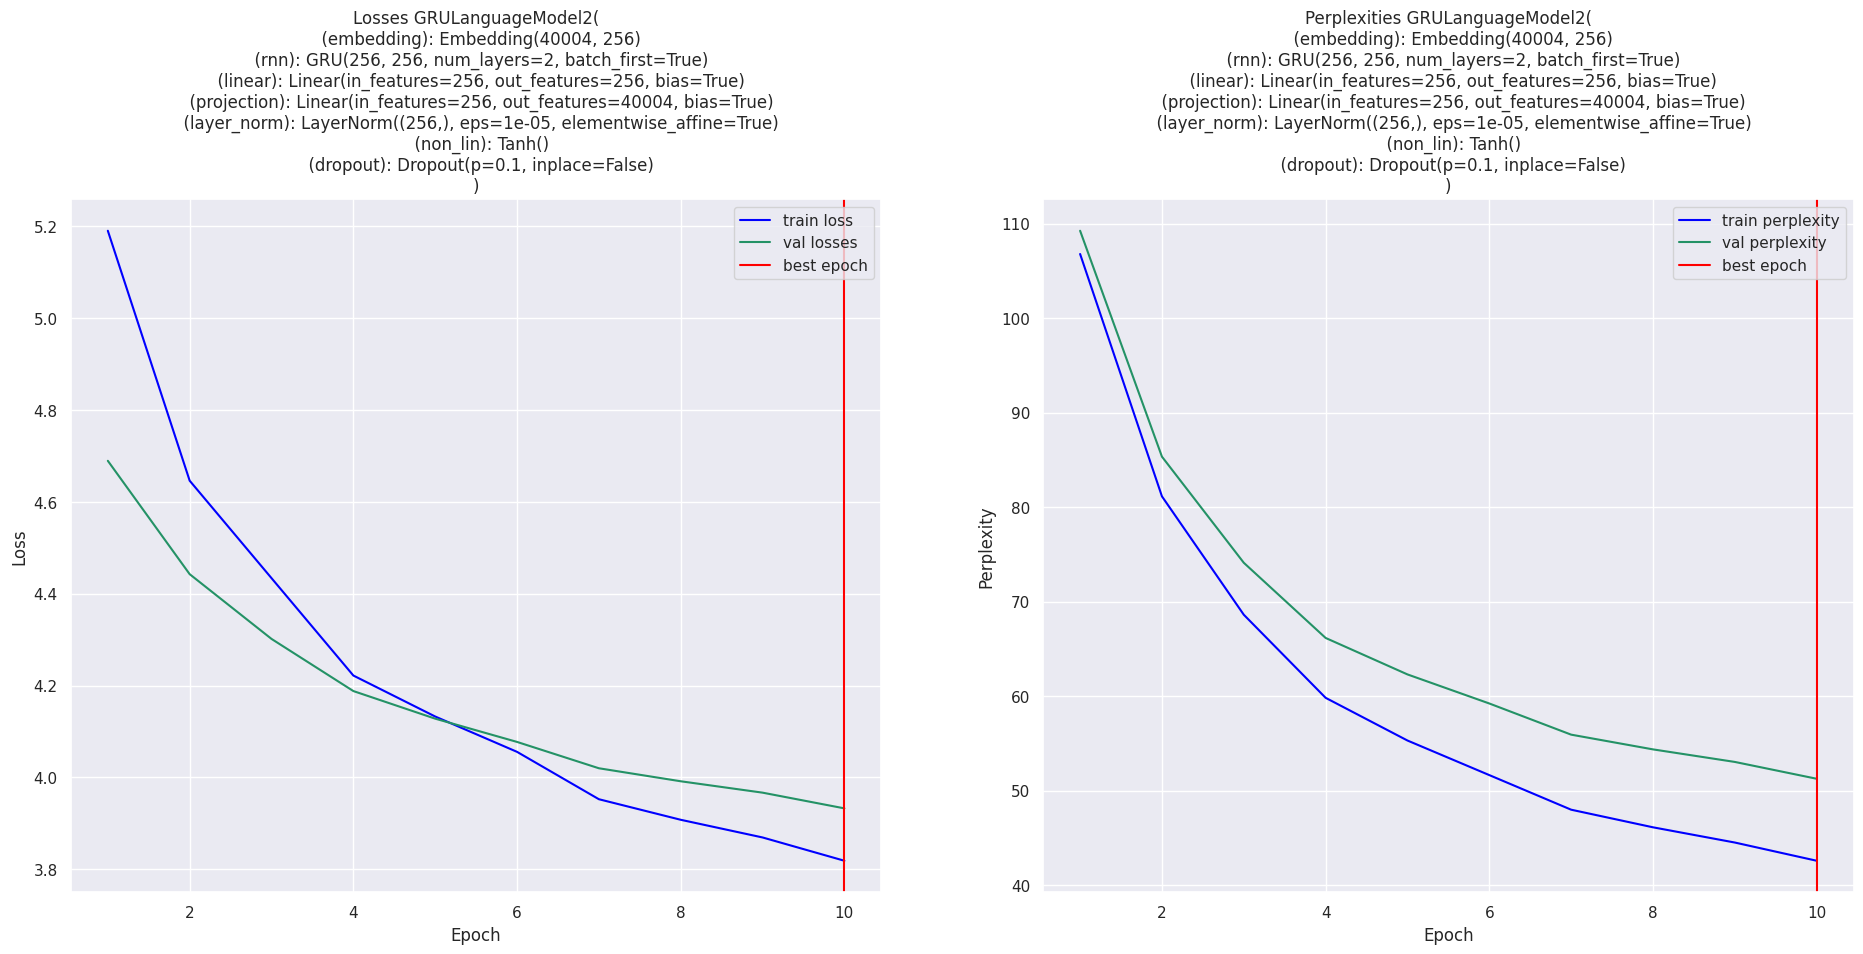

In [ ]:
epochs = 10
gru2_train_losses, gru2_val_losses, gru2_train_perp, gru2_val_perp, gru2_time = train_model(
    model_gru2, train_dataloader, eval_dataloader, criterion, optimizer, clip, scheduler, epochs
)

In [ ]:
gru2_test_perp = evaluate(model_gru2, criterion, test_dataloader)
print(f"Test perplexity: {gru2_test_perp}")

Test perplexity: 51.15143136538787


In [ ]:
print(generate_sequence(model_gru2, starting_seq="don't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very"))
print("\nOriginal:", "\ndon't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very badly.")

<bos> do n't get me wrong , george c. scott was terrific as scrooge , but the rest of the cast fails so very well . <eos>

Original: 
don't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very badly.


In [ ]:
print(generate_sequence(model_gru2, starting_seq="saw this movie in my english class this afternoon and was surprised by how bad this version"))
print("\nOriginal:", "\nsaw this movie in my english class this afternoon and was surprised by how bad this version was.")

<bos> saw this movie in my english class this afternoon and was surprised by how bad this version was . <eos>

Original: 
saw this movie in my english class this afternoon and was surprised by how bad this version was.


In [ ]:
print(generate_sequence(model_gru2, starting_seq='every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch'))
print("\nOriginal:", '\nevery review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch it')

<bos> every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch . <eos>

Original: 
every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch it


In [ ]:
print(generate_sequence(model_gru2, starting_seq="if you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main"))
print("\nOriginal:", "\nif you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main characters.")

<bos> if you 've read this far , you must really want to know ... a group of remarkably unscientific scientists comprise the main character . <eos>

Original: 
if you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main characters.


### Exp #4. GRU + LayerNorm + Adam with lr=3e-4 and betas=(0.5, 0.999).

In [ ]:
seed_torch(seed)
model_gru3 = GRULanguageModel2(hidden_dim=256, vocab_size=len(vocab), num_layers=2).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_gru3.parameters(), lr=3e-4, betas=(0.5, 0.999))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

Training epoch 1:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 5.5723493945083815
Train perplexity: 151.19142425433748


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 5.0218272629146
Val perplexity: 152.3436815111941
Best perplexity: 152.3436815111941
Time: 271.68472266197205


Training epoch 2:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.931375323464364
Train perplexity: 116.83103044915259


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.775918202025458
Val perplexity: 119.14029869348376
Best perplexity: 119.14029869348376
Time: 543.5911178588867


Training epoch 3:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.740155965367381
Train perplexity: 100.12864025480964


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.633783943930939
Val perplexity: 103.3509164618929
Best perplexity: 103.3509164618929
Time: 817.0147795677185


Training epoch 4:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.6012626489676425
Train perplexity: 91.9387167559954


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.5562457689424845
Val perplexity: 95.63993131435984
Best perplexity: 95.63993131435984
Time: 1089.7662727832794


Training epoch 5:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.540216688984637
Train perplexity: 86.73429544369716


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.504894667524632
Val perplexity: 90.84689212168459
Best perplexity: 90.84689212168459
Time: 1363.0875129699707


Training epoch 6:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.4878098175345995
Train perplexity: 82.37305401019582


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.460130645653742
Val perplexity: 86.86530813615174
Best perplexity: 86.86530813615174
Time: 1636.3199684619904


Training epoch 7:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.430503897703269
Train perplexity: 79.39371983385207


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.427736915547027
Val perplexity: 84.09581778301457
Best perplexity: 84.09581778301457
Time: 1909.2302145957947


Training epoch 8:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.405474526310855
Train perplexity: 77.50286909809161


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.407339771911704
Val perplexity: 82.3961464331402
Best perplexity: 82.3961464331402
Time: 2182.626777648926


Training epoch 9:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.382908590964399
Train perplexity: 75.6940424868255


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.387388677131839
Val perplexity: 80.76608046348179
Best perplexity: 80.76608046348179
Time: 2457.530122756958


Training epoch 10:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.355482563742331
Train perplexity: 74.38797089126936


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.372313724946847
Val perplexity: 79.55728343767203
Best perplexity: 79.55728343767203
Time: 2731.2404613494873


<ipython-input-30-8aa5311c88fd>:50: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


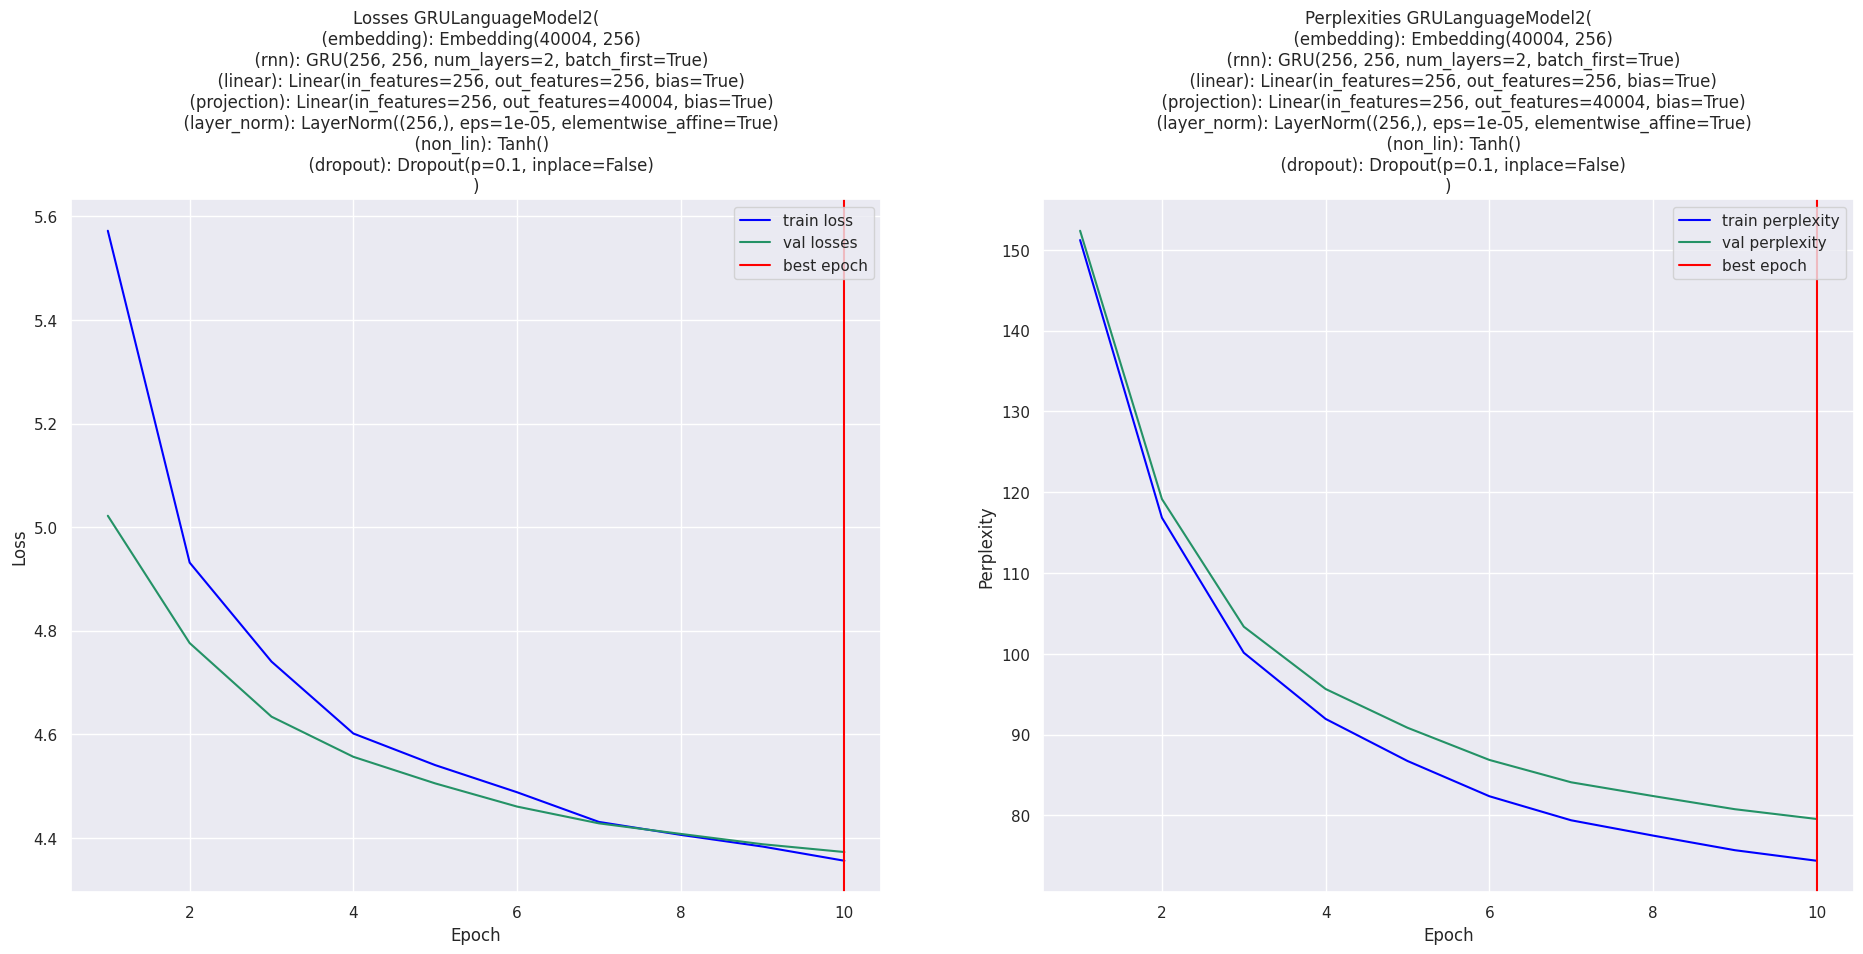

In [ ]:
epochs = 10
gru3_train_losses, gru3_val_losses, gru3_train_perp, gru3_val_perp, gru3_time = train_model(
    model_gru3, train_dataloader, eval_dataloader, criterion, optimizer, clip, scheduler, epochs
)

In [ ]:
gru3_test_perp = evaluate(model_gru3, criterion, test_dataloader)
print(f"Test perplexity: {gru3_test_perp}")

Test perplexity: 79.61119892668272


In [ ]:
print(generate_sequence(model_gru3, starting_seq="don't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very"))
print("\nOriginal:", "\ndon't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very badly.")

<bos> do n't get me wrong , george c. scott was terrific as scrooge , but the rest of the cast fails so very well . <eos>

Original: 
don't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very badly.


In [ ]:
print(generate_sequence(model_gru3, starting_seq="saw this movie in my english class this afternoon and was surprised by how bad this version"))
print("\nOriginal:", "\nsaw this movie in my english class this afternoon and was surprised by how bad this version was.")

<bos> saw this movie in my english class this afternoon and was surprised by how bad this version was . <eos>

Original: 
saw this movie in my english class this afternoon and was surprised by how bad this version was.


In [ ]:
print(generate_sequence(model_gru3, starting_seq='every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch'))
print("\nOriginal:", '\nevery review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch it')

<bos> every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch . <eos>

Original: 
every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch it


In [ ]:
print(generate_sequence(model_gru3, starting_seq="if you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main"))
print("\nOriginal:", "\nif you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main characters.")

<bos> if you 've read this far , you must really want to know ... a group of remarkably unscientific scientists comprise the main character . <eos>

Original: 
if you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main characters.


### Exp #5. GRU + LayerNorm + SGD with Nesterov momentum.

In [ ]:
seed_torch(seed)
model_gru4 = GRULanguageModel2(hidden_dim=256, vocab_size=len(vocab), num_layers=2).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.SGD(model_gru4.parameters(), lr=2e-1, momentum=0.9, nesterov=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

Training epoch 1:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 5.38911626986989
Train perplexity: 149.38491173339636


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 5.005556348216566
Val perplexity: 149.9684046406733
Best perplexity: 149.9684046406733
Time: 268.0360929965973


Training epoch 2:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.928203204847008
Train perplexity: 121.13930062496692


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.8039850264706905
Val perplexity: 122.59692356967668
Best perplexity: 122.59692356967668
Time: 535.437956571579


Training epoch 3:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.781409050023323
Train perplexity: 107.96502566034768


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.696505916150928
Val perplexity: 110.10275549746464
Best perplexity: 110.10275549746464
Time: 802.8146815299988


Training epoch 4:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.661777536309845
Train perplexity: 98.72929079990888


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.613812403304144
Val perplexity: 101.36305417730233
Best perplexity: 101.36305417730233
Time: 1069.9938197135925


Training epoch 5:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.615363010403264
Train perplexity: 94.57775918958956


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.575620755916688
Val perplexity: 97.56264527897201
Best perplexity: 97.56264527897201
Time: 1338.1309237480164


Training epoch 6:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.577378803950866
Train perplexity: 91.15642324733491


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.5433157692110635
Val perplexity: 94.45997946307588
Best perplexity: 94.45997946307588
Time: 1605.6307940483093


Training epoch 7:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.520592836885509
Train perplexity: 87.10377098038275


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.502933104832967
Val perplexity: 90.71932204952085
Best perplexity: 90.71932204952085
Time: 1872.8684084415436


Training epoch 8:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.4997202645510965
Train perplexity: 85.4195763751877


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.4865668349795875
Val perplexity: 89.24639233018002
Best perplexity: 89.24639233018002
Time: 2141.157045841217


Training epoch 9:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.4819526030389465
Train perplexity: 83.91039678588143


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.471671842947239
Val perplexity: 87.92587257529985
Best perplexity: 87.92587257529985
Time: 2408.9533536434174


Training epoch 10:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.450267593907058
Train perplexity: 81.96231309404624


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.451480170252523
Val perplexity: 86.16948981142949
Best perplexity: 86.16948981142949
Time: 2676.6469156742096


<ipython-input-30-8aa5311c88fd>:50: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


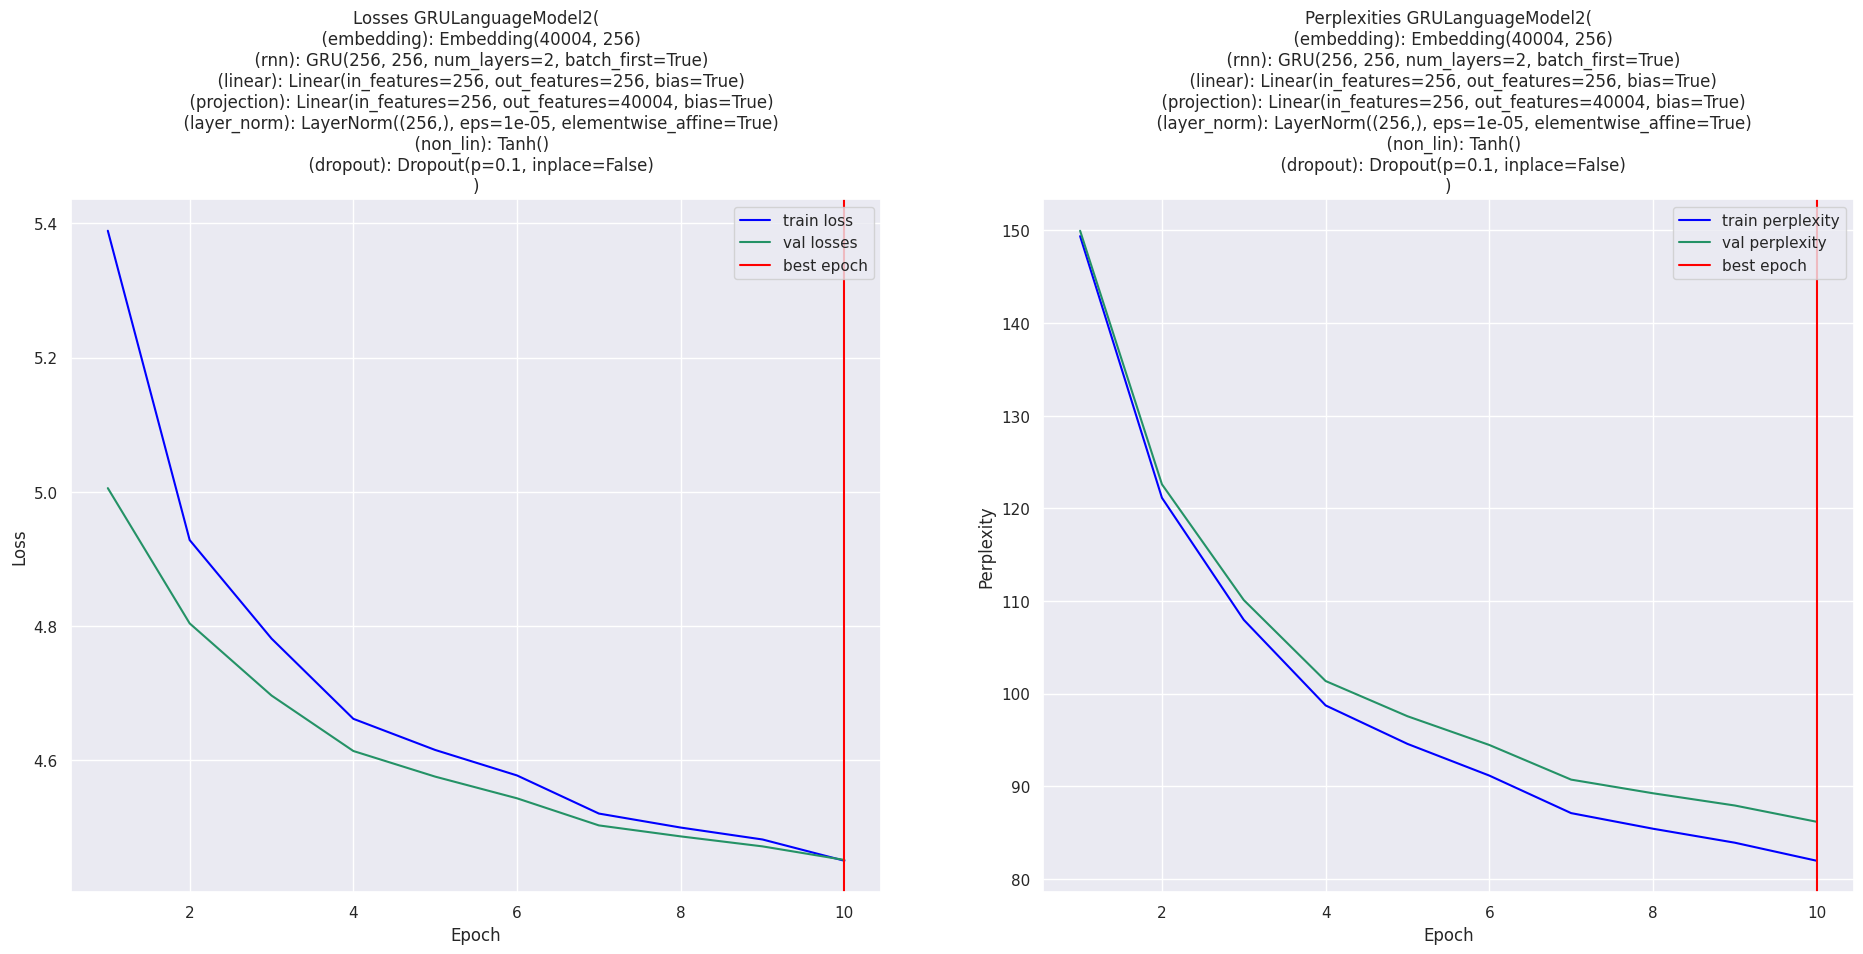

In [ ]:
epochs = 10
gru4_train_losses, gru4_val_losses, gru4_train_perp, gru4_val_perp, gru4_time = train_model(
    model_gru4, train_dataloader, eval_dataloader, criterion, optimizer, clip, scheduler, epochs
)

In [ ]:
gru4_test_perp = evaluate(model_gru4, criterion, test_dataloader)
print(f"Test perplexity: {gru4_test_perp}")

Test perplexity: 86.44089228932451


In [ ]:
print(generate_sequence(model_gru4, starting_seq="don't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very"))
print("\nOriginal:", "\ndon't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very badly.")

<bos> do n't get me wrong , george c. scott was terrific as scrooge , but the rest of the cast fails so very much . <eos>

Original: 
don't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very badly.


In [ ]:
print(generate_sequence(model_gru4, starting_seq="saw this movie in my english class this afternoon and was surprised by how bad this version"))
print("\nOriginal:", "\nsaw this movie in my english class this afternoon and was surprised by how bad this version was.")

<bos> saw this movie in my english class this afternoon and was surprised by how bad this version was . <eos>

Original: 
saw this movie in my english class this afternoon and was surprised by how bad this version was.


In [ ]:
print(generate_sequence(model_gru4, starting_seq='every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch'))
print("\nOriginal:", '\nevery review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch it')

<bos> every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch . <eos>

Original: 
every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch it


In [ ]:
print(generate_sequence(model_gru4, starting_seq="if you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main"))
print("\nOriginal:", "\nif you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main characters.")

<bos> if you 've read this far , you must really want to know ... a group of remarkably unscientific scientists comprise the main character . <eos>

Original: 
if you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main characters.


### Exp #6. GRU + LayerNorm + RMSProp.

In [ ]:
seed_torch(seed)
model_gru5 = GRULanguageModel2(hidden_dim=256, vocab_size=len(vocab), num_layers=2).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.RMSprop(model_gru5.parameters(), lr=5e-3, centered=True, foreach=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

Training epoch 1:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 5.353728745369261
Train perplexity: 137.88104456062544


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.939955289447857
Val perplexity: 140.39198141950902
Best perplexity: 140.39198141950902
Time: 272.263973236084


Training epoch 2:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.867063065285808
Train perplexity: 114.04572881751905


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.763230573194137
Val perplexity: 117.64411268776995
Best perplexity: 117.64411268776995
Time: 544.2094106674194


Training epoch 3:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.710004863448309
Train perplexity: 101.75664327106266


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.661213459361213
Val perplexity: 106.21292423362009
Best perplexity: 106.21292423362009
Time: 815.8618803024292


Training epoch 4:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.513715074993008
Train perplexity: 86.10619671762646


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.515827753356478
Val perplexity: 91.8451929273321
Best perplexity: 91.8451929273321
Time: 1086.543978214264


Training epoch 5:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.42596959098732
Train perplexity: 81.27111562685276


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.472161112115958
Val perplexity: 87.9206759341687
Best perplexity: 87.9206759341687
Time: 1358.4193687438965


Training epoch 6:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.360792294889058
Train perplexity: 78.26165468828039


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.446735763291357
Val perplexity: 85.7149545933173
Best perplexity: 85.7149545933173
Time: 1633.036330461502


Training epoch 7:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.235427021879346
Train perplexity: 69.17674248426471


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.346529627880106
Val perplexity: 77.54415928703659
Best perplexity: 77.54415928703659
Time: 1906.4102983474731


Training epoch 8:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.175164621629319
Train perplexity: 66.4467880449287


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.318648464311429
Val perplexity: 75.4109075024199
Best perplexity: 75.4109075024199
Time: 2178.0547862052917


Training epoch 9:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.129442783455844
Train perplexity: 64.55067616009693


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.300116526079049
Val perplexity: 74.02642369981058
Best perplexity: 74.02642369981058
Time: 2449.4836394786835


Training epoch 10:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.057433356277827
Train perplexity: 59.700011562634884


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.237164951598418
Val perplexity: 69.50925888537068
Best perplexity: 69.50925888537068
Time: 2721.489259958267


<ipython-input-30-8aa5311c88fd>:50: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


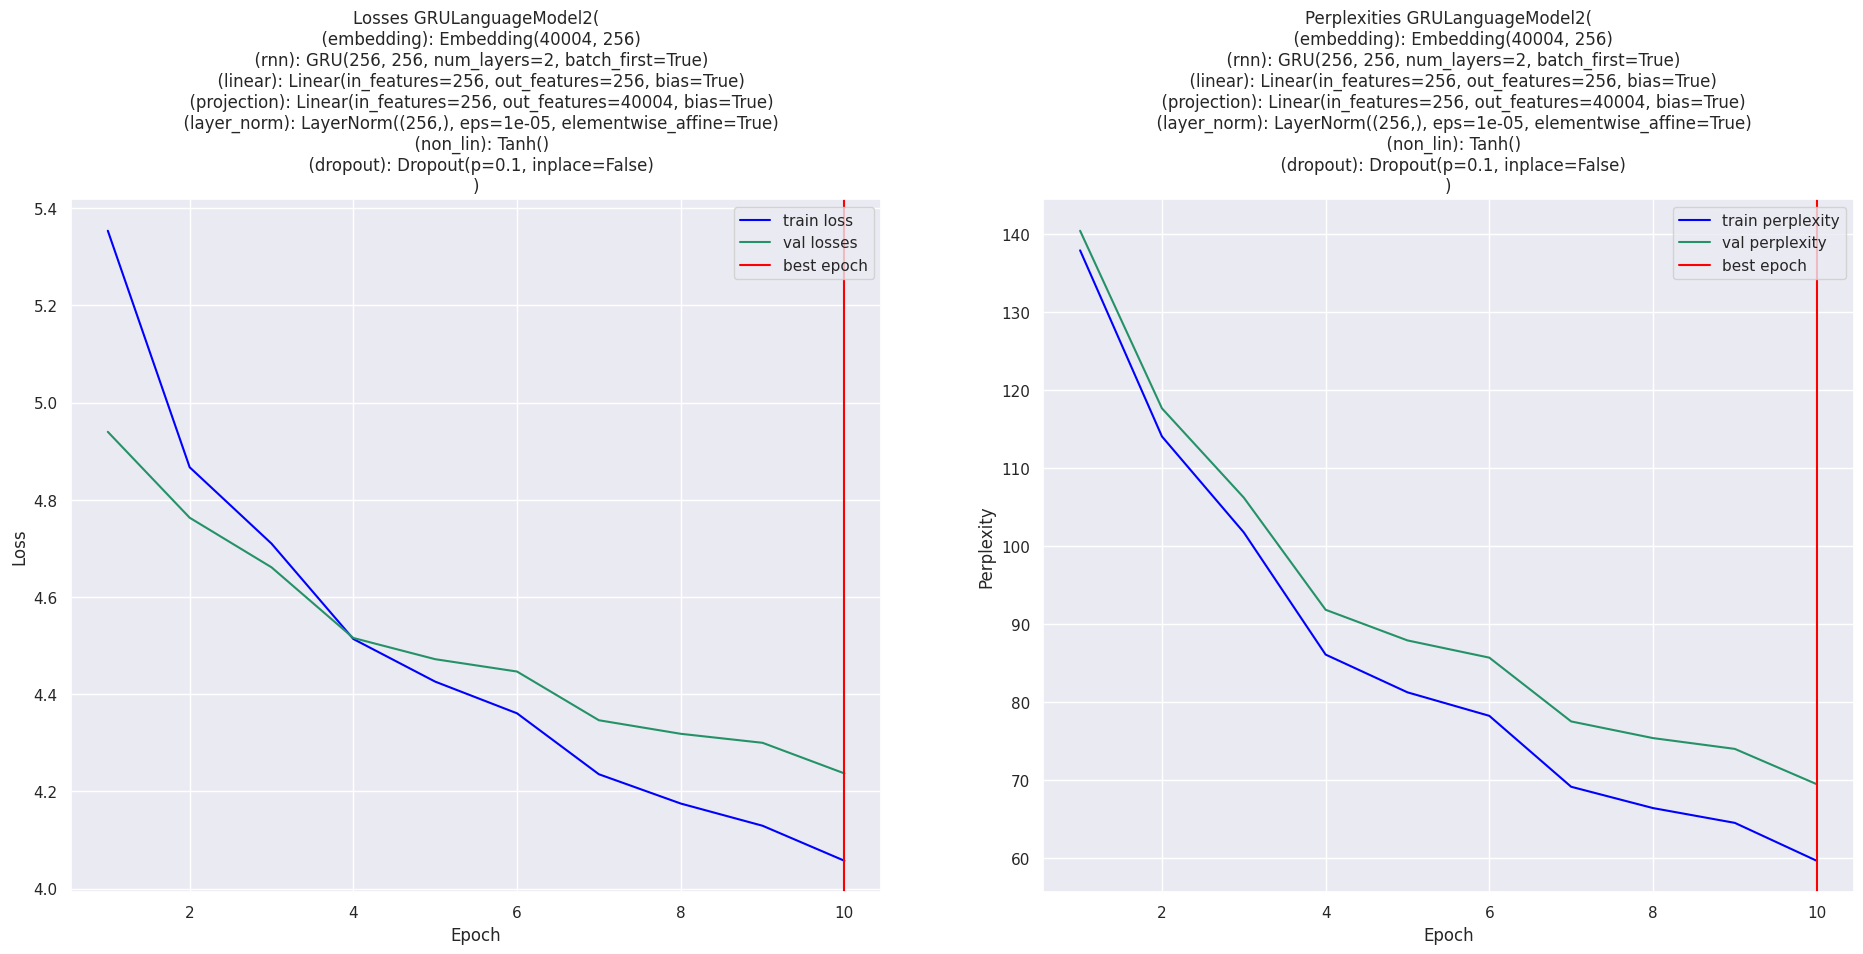

In [ ]:
epochs = 10
gru5_train_losses, gru5_val_losses, gru5_train_perp, gru5_val_perp, gru5_time = train_model(
    model_gru5, train_dataloader, eval_dataloader, criterion, optimizer, clip, scheduler, epochs
)

In [ ]:
gru5_test_perp = evaluate(model_gru5, criterion, test_dataloader)
print(f"Test perplexity: {gru5_test_perp}")

Test perplexity: 69.34246312376607


In [ ]:
print(generate_sequence(model_gru5, starting_seq="don't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very"))
print("\nOriginal:", "\ndon't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very badly.")

<bos> do n't get me wrong , george c. scott was terrific as scrooge , but the rest of the cast fails so very hard to impress me . <eos>

Original: 
don't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very badly.


In [ ]:
print(generate_sequence(model_gru5, starting_seq="saw this movie in my english class this afternoon and was surprised by how bad this version"))
print("\nOriginal:", "\nsaw this movie in my english class this afternoon and was surprised by how bad this version was.")

<bos> saw this movie in my english class this afternoon and was surprised by how bad this version was . <eos>

Original: 
saw this movie in my english class this afternoon and was surprised by how bad this version was.


In [ ]:
print(generate_sequence(model_gru5, starting_seq='every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch'))
print("\nOriginal:", '\nevery review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch it')

<bos> every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch it . <eos>

Original: 
every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch it


In [ ]:
print(generate_sequence(model_gru5, starting_seq="if you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main"))
print("\nOriginal:", "\nif you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main characters.")

<bos> if you 've read this far , you must really want to know ... a group of remarkably unscientific scientists comprise the main character . <eos>

Original: 
if you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main characters.


### Exp #7. GRU + LayerNorm + GELU + Adam.

In [ ]:
class GRULanguageModel3(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.layer_norm = nn.LayerNorm(hidden_dim)

        self.non_lin = nn.GELU()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch) # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings) # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(self.layer_norm(output)))) # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(self.layer_norm(output))) # [batch_size, seq_len, vocab_size]

        return projection

In [ ]:
seed_torch(seed)
model_gru6 = GRULanguageModel3(hidden_dim=256, vocab_size=len(vocab), num_layers=2).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_gru6.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

Training epoch 1:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 5.152136668222219
Train perplexity: 99.12951340703617


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.630892906731706
Val perplexity: 103.0648394018654
Best perplexity: 103.0648394018654
Time: 263.6991910934448


Training epoch 2:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.552550358251431
Train perplexity: 74.65959836102259


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.380416092833852
Val perplexity: 80.20444177870505
Best perplexity: 80.20444177870505
Time: 534.960771560669


Training epoch 3:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.322756145890742
Train perplexity: 62.72499756647509


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.237880322022167
Val perplexity: 69.5390947646888
Best perplexity: 69.5390947646888
Time: 822.8869142532349


Training epoch 4:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.107094057730756
Train perplexity: 54.332513775288504


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.124094472021914
Val perplexity: 62.06198196100995
Best perplexity: 62.06198196100995
Time: 1106.0915603637695


Training epoch 5:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.00754307509478
Train perplexity: 49.84896184548193


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.0618001926882155
Val perplexity: 58.315912861811114
Best perplexity: 58.315912861811114
Time: 1389.4179728031158


Training epoch 6:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 3.9208731479709376
Train perplexity: 46.144462302819235


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.008343059519119
Val perplexity: 55.285258476650164
Best perplexity: 55.285258476650164
Time: 1657.571149110794


Training epoch 7:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 3.814962076595736
Train perplexity: 42.36405040569774


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.9435268365916842
Val perplexity: 51.820245050156345
Best perplexity: 51.820245050156345
Time: 1921.5196285247803


Training epoch 8:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 3.765024867933953
Train perplexity: 40.50541616434974


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.91418802188987
Val perplexity: 50.3267321496152
Best perplexity: 50.3267321496152
Time: 2185.67276930809


Training epoch 9:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 3.7217017445495633
Train perplexity: 38.881807320810395


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.888116990647665
Val perplexity: 49.03769620259603
Best perplexity: 49.03769620259603
Time: 2450.027936697006


Training epoch 10:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 3.671453511482775
Train perplexity: 36.96855891467554


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.8500420200792433
Val perplexity: 47.208382428177
Best perplexity: 47.208382428177
Time: 2714.2653501033783


<ipython-input-25-8aa5311c88fd>:50: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


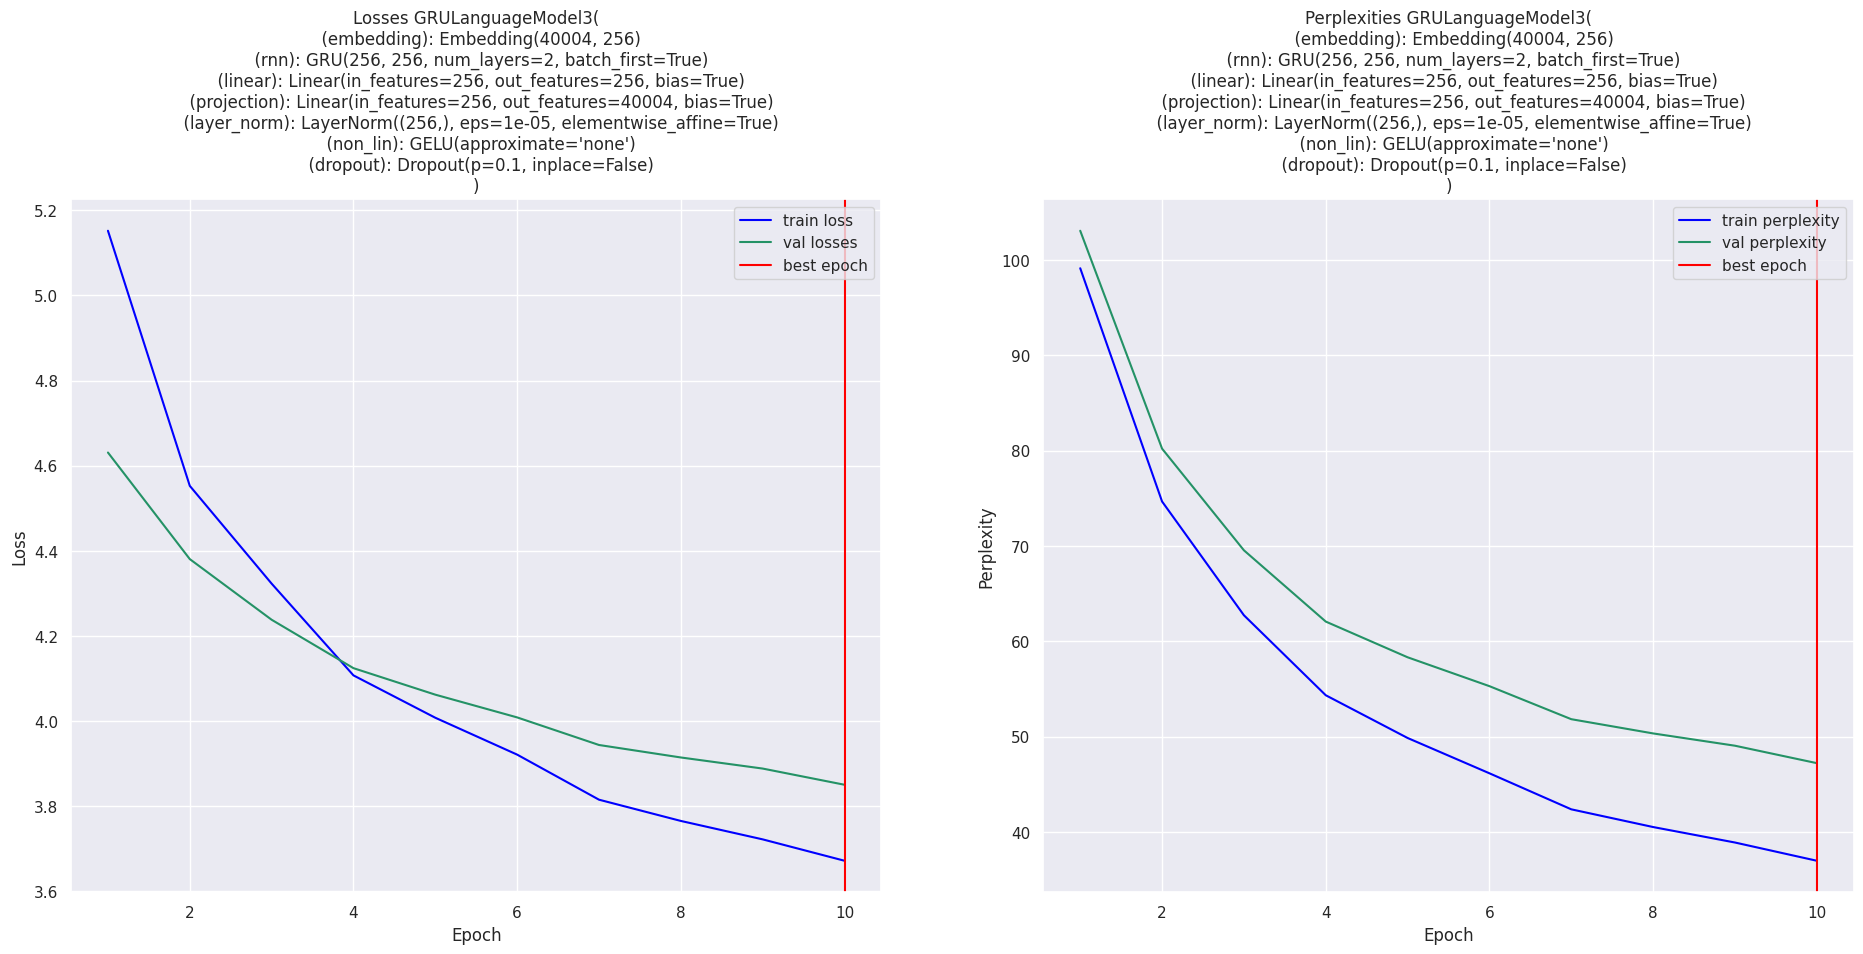

In [ ]:
epochs = 10
gru6_train_losses, gru6_val_losses, gru6_train_perp, gru6_val_perp, gru6_time = train_model(
    model_gru6, train_dataloader, eval_dataloader, criterion, optimizer, clip, scheduler, epochs
)

In [ ]:
gru6_test_perp = evaluate(model_gru6, criterion, test_dataloader)
print(f"Test perplexity: {gru6_test_perp}")

Test perplexity: 46.90679399753974


In [ ]:
print(generate_sequence(model_gru6, starting_seq="don't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very"))
print("\nOriginal:", "\ndon't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very badly.")

<bos> do n't get me wrong , george c. scott was terrific as scrooge , but the rest of the cast fails so very well . <eos>

Original: 
don't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very badly.


In [ ]:
print(generate_sequence(model_gru6, starting_seq="saw this movie in my english class this afternoon and was surprised by how bad this version"))
print("\nOriginal:", "\nsaw this movie in my english class this afternoon and was surprised by how bad this version was.")

<bos> saw this movie in my english class this afternoon and was surprised by how bad this version was . <eos>

Original: 
saw this movie in my english class this afternoon and was surprised by how bad this version was.


In [ ]:
print(generate_sequence(model_gru6, starting_seq='every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch'))
print("\nOriginal:", '\nevery review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch it')

<bos> every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch . <eos>

Original: 
every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch it


In [ ]:
print(generate_sequence(model_gru6, starting_seq="if you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main"))
print("\nOriginal:", "\nif you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main characters.")

<bos> if you 've read this far , you must really want to know ... a group of remarkably unscientific scientists comprise the main character . <eos>

Original: 
if you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main characters.


### Exp #8. GRU + LayerNorm + Linear + GELU + Adam.

In [ ]:
class GRULanguageModel4(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_layers: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.layer_norm = nn.LayerNorm(hidden_dim)

        self.non_lin = nn.GELU()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch) # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings) # [batch_size, seq_len, hidden_dim]
        output = self.linear(self.non_lin(self.layer_norm(output))) # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(self.layer_norm(output)))) # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(self.layer_norm(output))) # [batch_size, seq_len, vocab_size]

        return projection

In [ ]:
seed_torch(seed)
model_gru7 = GRULanguageModel4(hidden_dim=256, vocab_size=len(vocab), num_layers=2).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_gru7.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

Training epoch 1:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 5.171126070918924
Train perplexity: 102.72597429370799


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.663608400479242
Val perplexity: 106.49027353509008
Best perplexity: 106.49027353509008
Time: 266.7161602973938


Training epoch 2:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.589869697047532
Train perplexity: 78.63968991143132


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.426936490748956
Val perplexity: 84.02888612824727
Best perplexity: 84.02888612824727
Time: 533.4452242851257


Training epoch 3:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.370508338514775
Train perplexity: 66.69934269697559


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.291304304024714
Val perplexity: 73.36141733619256
Best perplexity: 73.36141733619256
Time: 800.7664570808411


Training epoch 4:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.162957326927799
Train perplexity: 58.07477373192615


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.180655640638294
Val perplexity: 65.67913250289958
Best perplexity: 65.67913250289958
Time: 1066.5242986679077


Training epoch 5:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.067150450883328
Train perplexity: 53.478404546571326


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.120102902414999
Val perplexity: 61.82136433298995
Best perplexity: 61.82136433298995
Time: 1331.6793205738068


Training epoch 6:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 3.9838817741384354
Train perplexity: 49.7596168098159


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.069608444443886
Val perplexity: 58.78152191865089
Best perplexity: 58.78152191865089
Time: 1597.3026373386383


Training epoch 7:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 3.8822953836277923
Train perplexity: 46.00161881733506


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.009827765992017
Val perplexity: 55.37230842094111
Best perplexity: 55.37230842094111
Time: 1863.5658752918243


Training epoch 8:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 3.834106790322959
Train perplexity: 44.060566069613465


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.980814446924825
Val perplexity: 53.792826841194135
Best perplexity: 53.792826841194135
Time: 2129.5620543956757


Training epoch 9:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 3.791321966629933
Train perplexity: 42.36946423956139


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.9554904996541134
Val perplexity: 52.453132148680645
Best perplexity: 52.453132148680645
Time: 2395.7925651073456


Training epoch 10:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 3.7429899900874073
Train perplexity: 40.31593928874094


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.9174064998704243
Val perplexity: 50.49668587061771
Best perplexity: 50.49668587061771
Time: 2660.6669278144836


<ipython-input-25-8aa5311c88fd>:50: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


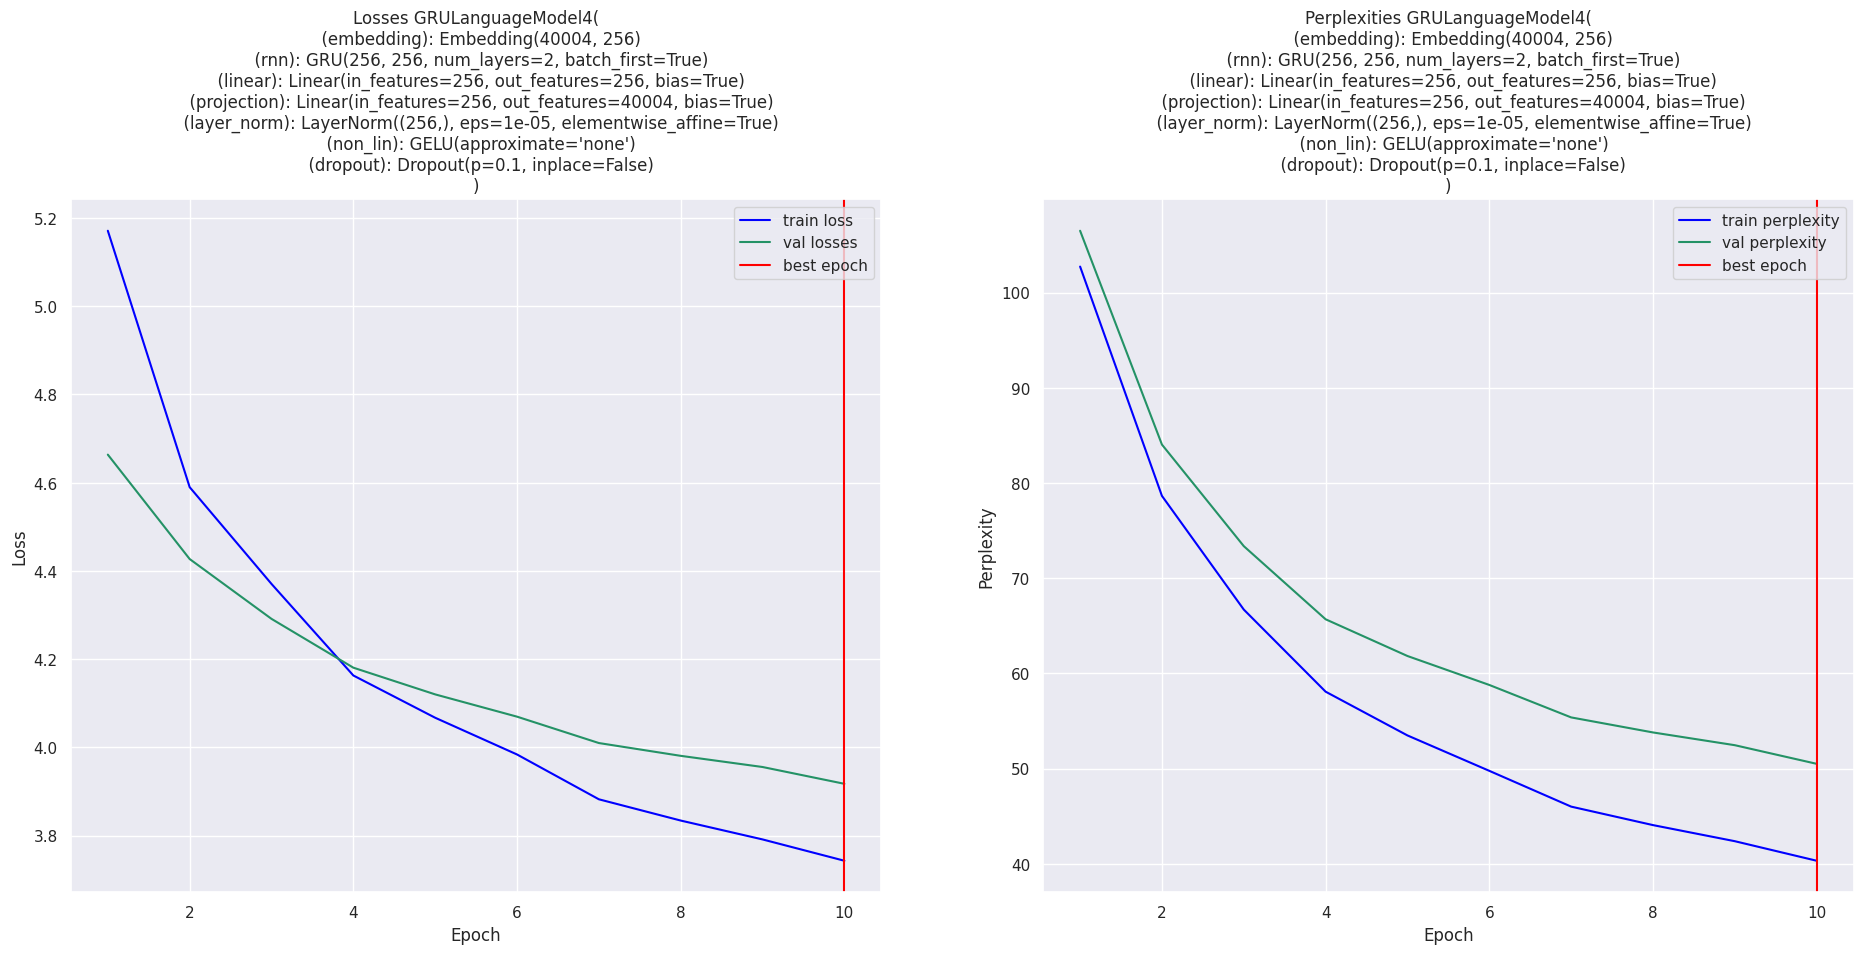

In [ ]:
epochs = 10
gru7_train_losses, gru7_val_losses, gru7_train_perp, gru7_val_perp, gru7_time = train_model(
    model_gru7, train_dataloader, eval_dataloader, criterion, optimizer, clip, scheduler, epochs
)

In [ ]:
gru7_test_perp = evaluate(model_gru7, criterion, test_dataloader)
print(f"Test perplexity: {gru7_test_perp}")

Test perplexity: 50.08897343560609


In [ ]:
print(generate_sequence(model_gru7, starting_seq="don't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very"))
print("\nOriginal:", "\ndon't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very badly.")

<bos> do n't get me wrong , george c. scott was terrific as scrooge , but the rest of the cast fails so very much so that it 's not . <eos>

Original: 
don't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very badly.


In [ ]:
print(generate_sequence(model_gru7, starting_seq="saw this movie in my english class this afternoon and was surprised by how bad this version"))
print("\nOriginal:", "\nsaw this movie in my english class this afternoon and was surprised by how bad this version was.")

<bos> saw this movie in my english class this afternoon and was surprised by how bad this version was . <eos>

Original: 
saw this movie in my english class this afternoon and was surprised by how bad this version was.


In [ ]:
print(generate_sequence(model_gru7, starting_seq='every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch'))
print("\nOriginal:", '\nevery review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch it')

<bos> every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch it . <eos>

Original: 
every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch it


In [ ]:
print(generate_sequence(model_gru7, starting_seq="if you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main"))
print("\nOriginal:", "\nif you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main characters.")

<bos> if you 've read this far , you must really want to know ... a group of remarkably unscientific scientists comprise the main character . <eos>

Original: 
if you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main characters.


### Exp #9. GRU + LayerNorm + GELU + Adam + hidden_dim = 512.

In [ ]:
seed_torch(seed)
model_gru8 = GRULanguageModel3(hidden_dim=512, vocab_size=len(vocab), num_layers=2).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_gru8.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

Training epoch 1:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.96290961410109
Train perplexity: 80.43438619925348


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.433059305356447
Val perplexity: 84.55742917151309
Best perplexity: 84.55742917151309
Time: 432.9095754623413


Training epoch 2:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.356709128411315
Train perplexity: 58.30005708253555


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.156129256496585
Val perplexity: 64.08087000032751
Best perplexity: 64.08087000032751
Time: 870.4458322525024


Training epoch 3:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.064654113679089
Train perplexity: 47.33955835831761


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.992284153212054
Val perplexity: 54.39557171643265
Best perplexity: 54.39557171643265
Time: 1302.729619026184


Training epoch 4:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 3.740411265637287
Train perplexity: 37.78176107576194


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.8217817793693647
Val perplexity: 45.8783035795217
Best perplexity: 45.8783035795217
Time: 1733.476071357727


Training epoch 5:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 3.551104656020834
Train perplexity: 32.9311152715788


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.7301852602945758
Val perplexity: 41.87824863599245
Best perplexity: 41.87824863599245
Time: 2159.7788610458374


Training epoch 6:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 3.3837549557229605
Train perplexity: 29.23986969066817


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.657740939600358
Val perplexity: 38.97536252959957
Best perplexity: 38.97536252959957
Time: 2611.247771501541


Training epoch 7:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 3.202521727511077
Train perplexity: 24.83578906878892


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.543383837069276
Val perplexity: 34.7824981089853
Best perplexity: 34.7824981089853
Time: 3043.2124948501587


Training epoch 8:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 3.095609011133276
Train perplexity: 22.803630806247025


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.493455179015472
Val perplexity: 33.105429998258266
Best perplexity: 33.105429998258266
Time: 3490.5908460617065


Training epoch 9:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 3.0054664262566497
Train perplexity: 21.17407144842059


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.452987565580745
Val perplexity: 31.81168540964928
Best perplexity: 31.81168540964928
Time: 3933.913033723831


Training epoch 10:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 2.9254197559550494
Train perplexity: 18.8498381865822


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.3699833009301163
Val perplexity: 29.292167446477627
Best perplexity: 29.292167446477627
Time: 4380.733194112778


<ipython-input-25-8aa5311c88fd>:50: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


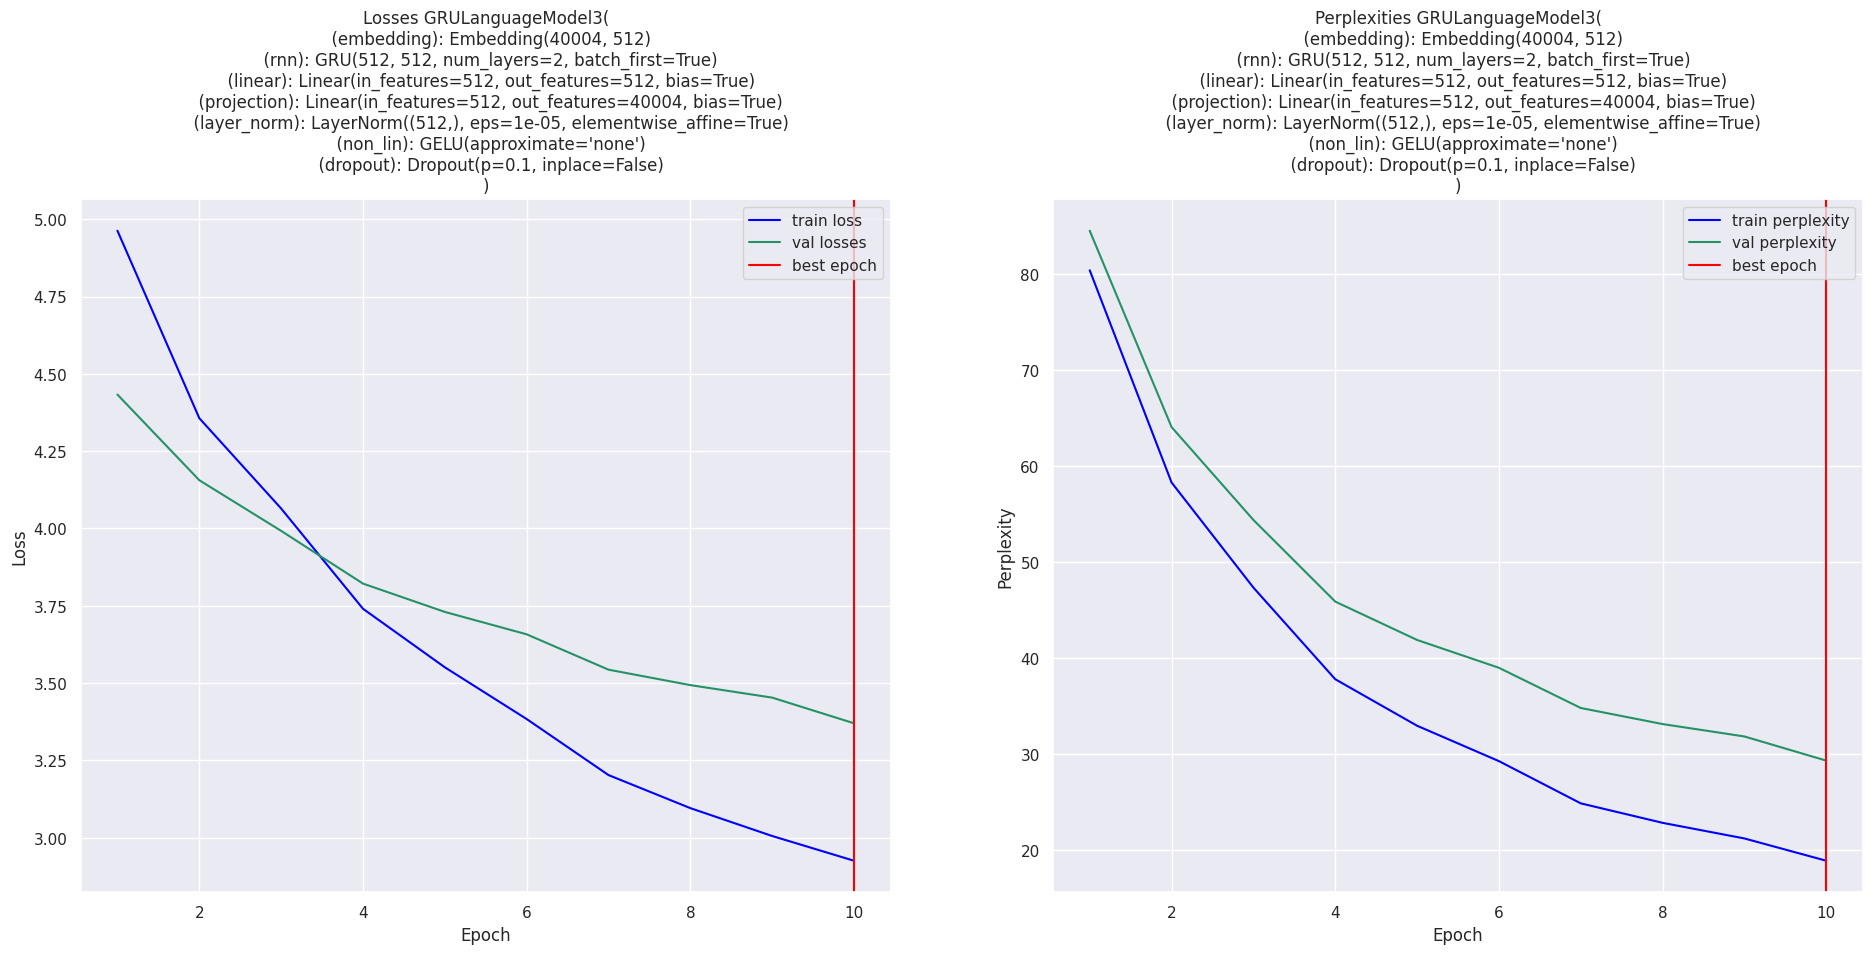

In [ ]:
epochs = 10
gru8_train_losses, gru8_val_losses, gru8_train_perp, gru8_val_perp, gru8_time = train_model(
    model_gru8, train_dataloader, eval_dataloader, criterion, optimizer, clip, scheduler, epochs
)

In [ ]:
gru8_test_perp = evaluate(model_gru8, criterion, test_dataloader)
print(f"Test perplexity: {gru8_test_perp}")

Test perplexity: 29.05991799010817


In [ ]:
print(generate_sequence(model_gru8, starting_seq="don't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very"))
print("\nOriginal:", "\ndon't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very badly.")

<bos> do n't get me wrong , george c. scott was terrific as scrooge , but the rest of the cast fails so very . <eos>

Original: 
don't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very badly.


In [ ]:
print(generate_sequence(model_gru8, starting_seq="saw this movie in my english class this afternoon and was surprised by how bad this version"))
print("\nOriginal:", "\nsaw this movie in my english class this afternoon and was surprised by how bad this version was.")

<bos> saw this movie in my english class this afternoon and was surprised by how bad this version was . <eos>

Original: 
saw this movie in my english class this afternoon and was surprised by how bad this version was.


In [ ]:
print(generate_sequence(model_gru8, starting_seq='every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch'))
print("\nOriginal:", '\nevery review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch it')

<bos> every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch it . <eos>

Original: 
every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch it


In [ ]:
print(generate_sequence(model_gru8, starting_seq="if you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main"))
print("\nOriginal:", "\nif you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main characters.")

<bos> if you 've read this far , you must really want to know ... a group of remarkably unscientific scientists comprise the main character . <eos>

Original: 
if you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main characters.


### Exp #10. LSTM + LayerNorm + GELU + Adam + hidden_dim = 512.

In [ ]:
seed_torch(seed)
model_lstm2 = LSTMLanguageModel(hidden_dim=512, vocab_size=len(vocab), num_layers=2,
                                 non_lin=nn.GELU, layer_norm=nn.LayerNorm).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_lstm2.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

Training epoch 1:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.938934370585158
Train perplexity: 77.8491889087958


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.400130528421583
Val perplexity: 81.81627169146448
Best perplexity: 81.81627169146448
Time: 443.4971430301666


Training epoch 2:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.3175890607212075
Train perplexity: 54.87328369470091


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.0975390814830295
Val perplexity: 60.43231810076127
Best perplexity: 60.43231810076127
Time: 882.8910100460052


Training epoch 3:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.008459957245545
Train perplexity: 42.86798943754579


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.902168202852492
Val perplexity: 49.70544338484767
Best perplexity: 49.70544338484767
Time: 1322.6588730812073


Training epoch 4:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 3.6620530391728647
Train perplexity: 33.453962872736945


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.715813107283781
Val perplexity: 41.26837548201646
Best perplexity: 41.26837548201646
Time: 1761.320838212967


Training epoch 5:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 3.4723500934927065
Train perplexity: 28.40370324867242


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.605180357529865
Val perplexity: 36.96355724076268
Best perplexity: 36.96355724076268
Time: 2199.7973103523254


Training epoch 6:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 3.3009878028559543
Train perplexity: 24.51263425311832


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.51226411279301
Val perplexity: 33.70683550382371
Best perplexity: 33.70683550382371
Time: 2639.1118025779724


Training epoch 7:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 3.096356330232838
Train perplexity: 20.686883046201082


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.3979797046682054
Val perplexity: 30.088273187962972
Best perplexity: 30.088273187962972
Time: 3078.2683885097504


Training epoch 8:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 2.9911104527496866
Train perplexity: 18.781958415284183


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.341934364016463
Val perplexity: 28.466479518549228
Best perplexity: 28.466479518549228
Time: 3518.021625995636


Training epoch 9:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 2.900339482902572
Train perplexity: 17.203388818939494


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.293004432021764
Val perplexity: 27.12670905415605
Best perplexity: 27.12670905415605
Time: 3957.5591225624084


Training epoch 10:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 2.7997355620604667
Train perplexity: 15.463921255423395


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.2223628281254757
Val perplexity: 25.292016070709643
Best perplexity: 25.292016070709643
Time: 4405.927613019943


<ipython-input-25-8aa5311c88fd>:50: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


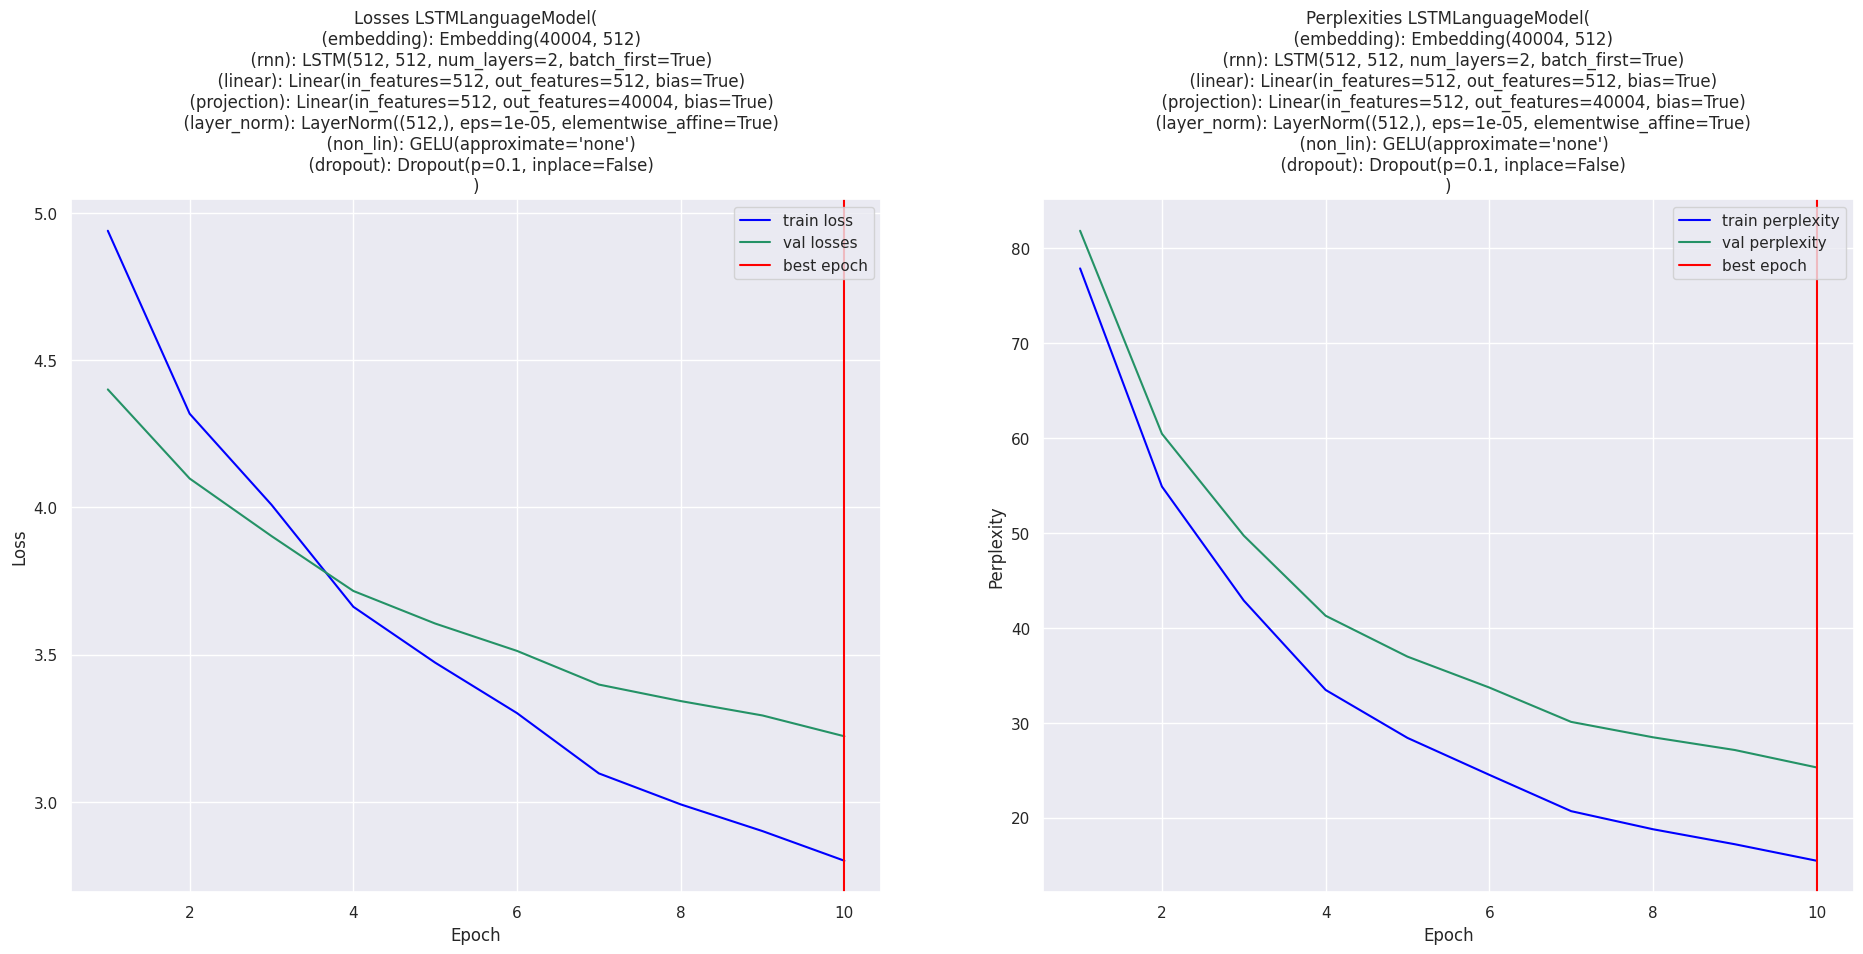

In [ ]:
epochs = 10
lstm2_train_losses, lstm2_val_losses, lstm2_train_perp, lstm2_val_perp, lstm2_time = train_model(
    model_lstm2, train_dataloader, eval_dataloader, criterion, optimizer, clip, scheduler, epochs
)

In [ ]:
lstm2_test_perp = evaluate(model_lstm2, criterion, test_dataloader)
print(f"Test perplexity: {lstm2_test_perp}")

Test perplexity: 25.112880130447348


In [ ]:
print(generate_sequence(model_lstm2, starting_seq="don't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very"))
print("\nOriginal:", "\ndon't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very badly.")

<bos> do n't get me wrong , george c. scott was terrific as scrooge , but the rest of the cast fails so very well . <eos>

Original: 
don't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very badly.


In [ ]:
print(generate_sequence(model_lstm2, starting_seq="saw this movie in my english class this afternoon and was surprised by how bad this version"))
print("\nOriginal:", "\nsaw this movie in my english class this afternoon and was surprised by how bad this version was.")

<bos> saw this movie in my english class this afternoon and was surprised by how bad this version was . <eos>

Original: 
saw this movie in my english class this afternoon and was surprised by how bad this version was.


In [ ]:
print(generate_sequence(model_lstm2, starting_seq='every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch'))
print("\nOriginal:", '\nevery review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch it')

<bos> every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch it . <eos>

Original: 
every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch it


In [ ]:
print(generate_sequence(model_lstm2, starting_seq="if you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main"))
print("\nOriginal:", "\nif you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main characters.")

<bos> if you 've read this far , you must really want to know ... a group of remarkably unscientific scientists comprise the main character . <eos>

Original: 
if you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main characters.


### Exp #11. LSTM + LayerNorm + GELU + Adam + hidden_dim = 1 024.

In [ ]:
seed_torch(seed)
model_lstm3 = LSTMLanguageModel(hidden_dim=1024, vocab_size=len(vocab), num_layers=2,
                                 non_lin=nn.GELU, layer_norm=nn.LayerNorm).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_lstm3.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

Training epoch 1:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.813916562069886
Train perplexity: 65.95954307795176


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 4.237969156203231
Val perplexity: 69.54620177312918
Best perplexity: 69.54620177312918
Time: 1028.979574918747


Training epoch 2:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 4.153289349779651
Train perplexity: 42.968226969797264


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.8702105732791146
Val perplexity: 48.136091144427375
Best perplexity: 48.136091144427375
Time: 2069.440678834915


Training epoch 3:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 3.7238469226798396
Train perplexity: 30.845673603086933


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.6121079227142543
Val perplexity: 37.20479841671662
Best perplexity: 37.20479841671662
Time: 3110.475150346756


Training epoch 4:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 3.170218020349514
Train perplexity: 19.91717540803953


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.2923640406874783
Val perplexity: 27.06358453187193
Best perplexity: 27.06358453187193
Time: 4151.723771572113


Training epoch 5:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 2.78549319440081
Train perplexity: 14.963705123833536


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 3.1190691236558
Val perplexity: 22.805220076708288
Best perplexity: 22.805220076708288
Time: 5194.749004840851


Training epoch 6:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 2.4437810583300354
Train perplexity: 11.787976924087111


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 2.997666965332135
Val perplexity: 20.25747505694547
Best perplexity: 20.25747505694547
Time: 6236.781023025513


Training epoch 7:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 2.0819984346905773
Train perplexity: 8.539201593722053


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 2.805575053543256
Val perplexity: 16.773303316214545
Best perplexity: 16.773303316214545
Time: 7280.517030000687


Training epoch 8:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 1.8618538132367954
Train perplexity: 7.224569828605167


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 2.7391409844886967
Val perplexity: 15.748163406764911
Best perplexity: 15.748163406764911
Time: 8325.597116708755


Training epoch 9:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 1.6885770916635965
Train perplexity: 6.311282374614583


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 2.7008915577477555
Val perplexity: 15.21362994227629
Best perplexity: 15.21362994227629
Time: 9369.501382827759


Training epoch 10:   0%|          | 0/1181 [00:00<?, ?it/s]

Train loss: 1.5323978074014843
Train perplexity: 5.162428543085167


  0%|          | 0/738 [00:00<?, ?it/s]

Val loss: 2.5875231276359663
Val perplexity: 13.625912069951292
Best perplexity: 13.625912069951292
Time: 10413.15014410019


<ipython-input-24-8aa5311c88fd>:50: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


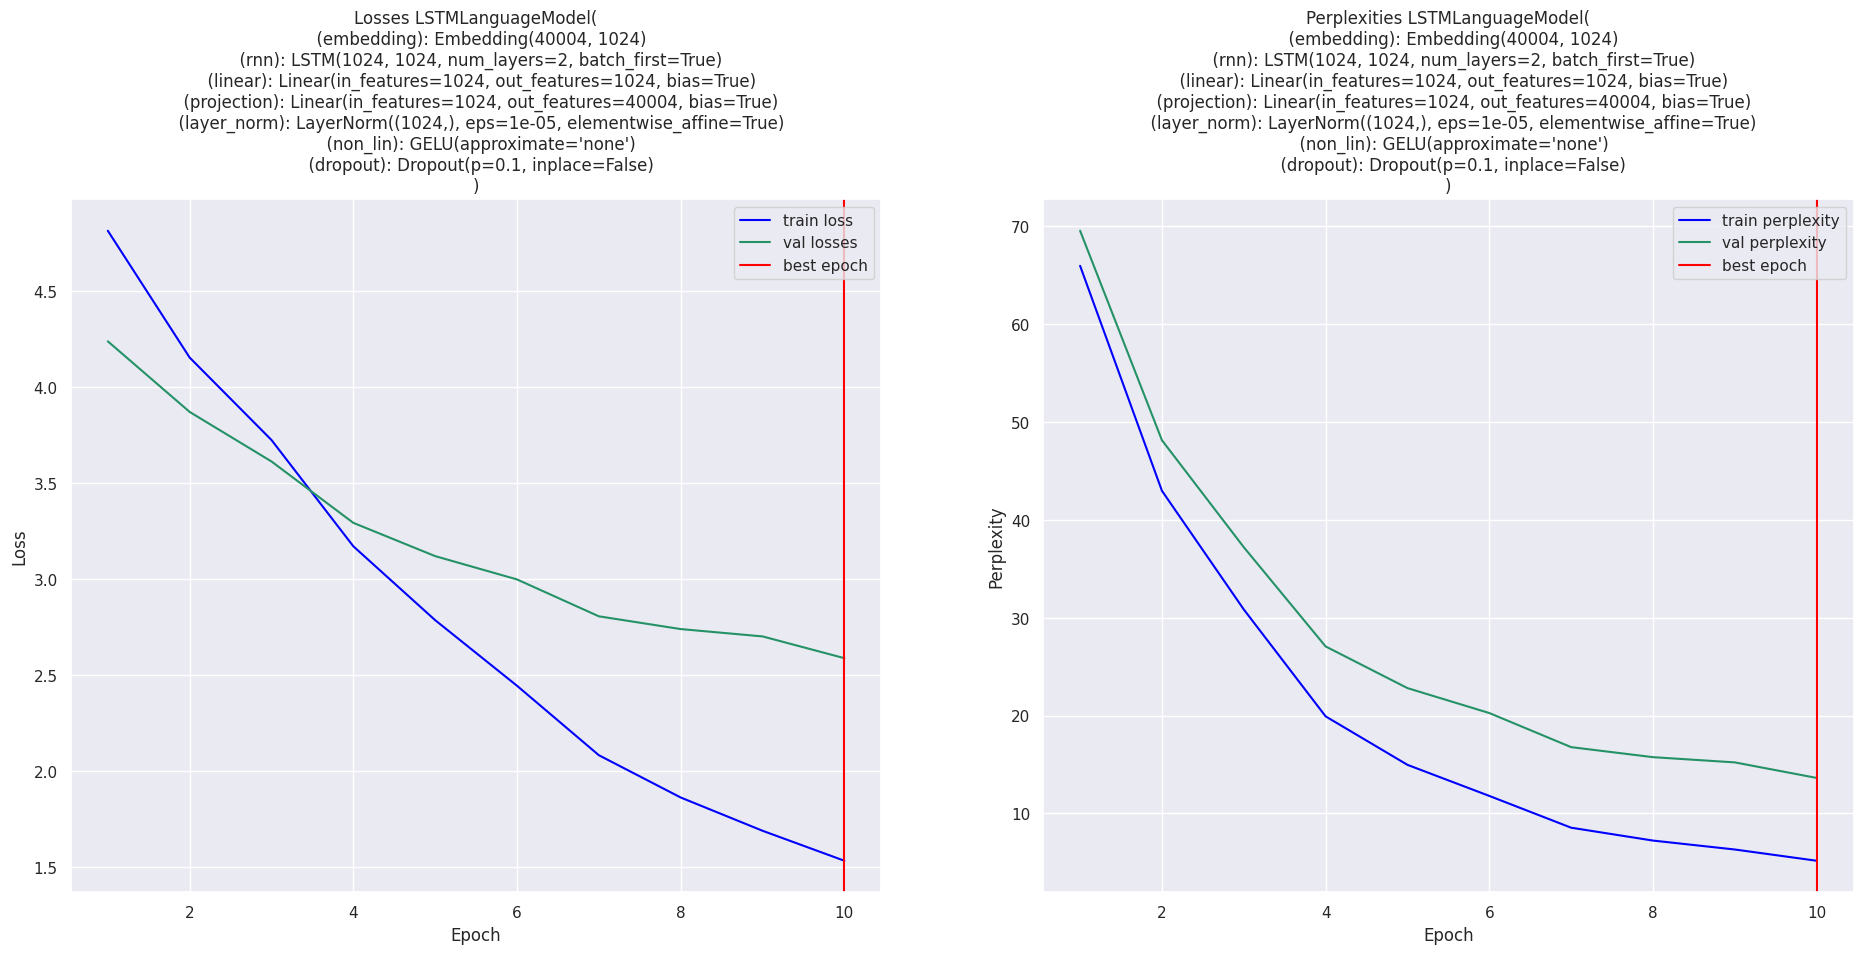

In [ ]:
epochs = 10
lstm3_train_losses, lstm3_val_losses, lstm3_train_perp, lstm3_val_perp, lstm3_time = train_model(
    model_lstm3, train_dataloader, eval_dataloader, criterion, optimizer, clip, scheduler, epochs
)

In [ ]:
lstm3_test_perp = evaluate(model_lstm3, criterion, test_dataloader)
print(f"Test perplexity: {lstm3_test_perp}")

Test perplexity: 13.620000280338898


In [ ]:
print(generate_sequence(model_lstm3, starting_seq="don't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very"))
print("\nOriginal:", "\ndon't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very badly.")

<bos> do n't get me wrong , george c. scott was terrific as scrooge , but the rest of the cast fails so very badly . <eos>

Original: 
don't get me wrong, george c. scott was terrific as scrooge, but the rest of the cast fails so very badly.


In [ ]:
print(generate_sequence(model_lstm3, starting_seq="saw this movie in my english class this afternoon and was surprised by how bad this version"))
print("\nOriginal:", "\nsaw this movie in my english class this afternoon and was surprised by how bad this version was.")

<bos> saw this movie in my english class this afternoon and was surprised by how bad this version was . <eos>

Original: 
saw this movie in my english class this afternoon and was surprised by how bad this version was.


In [ ]:
print(generate_sequence(model_lstm3, starting_seq='every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch'))
print("\nOriginal:", '\nevery review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch it')

<bos> every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch it . <eos>

Original: 
every review of the film basically said that this movie was so bad that it would make you bleed from the eyes to watch it


In [ ]:
print(generate_sequence(model_lstm3, starting_seq="if you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main"))
print("\nOriginal:", "\nif you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main characters.")

<bos> if you 've read this far , you must really want to know ... a group of remarkably unscientific scientists comprise the main role into a movie . <eos>

Original: 
if you've read this far, you must really want to know... a group of remarkably unscientific scientists comprise the main characters.


# Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

In [ ]:
training_time = [gru_time, lstm_time, gru2_time, gru3_time, gru4_time, gru5_time,
                 gru6_time, gru7_time, gru8_time, lstm2_time, lstm3_time]
for i in range(len(training_time)):
    training_time[i] = str(int(training_time[i] // 3600 % 24)) + ' h : ' + str(int(training_time[i] % 3600 // 60 // 10)) + str(int(training_time[i] % 3600 // 60 % 10)) + ' min : ' + str(int(training_time[i] % 60 // 10)) + str(int(training_time[i] % 60 % 10)) + ' sec'
print(training_time[8])

1 h : 13 min : 00 sec


In [ ]:
test_perplexities = [gru_test_perp, lstm_test_perp, gru2_test_perp, gru3_test_perp,
                     gru4_test_perp, gru5_test_perp, gru6_test_perp, gru7_test_perp,
                     gru8_test_perp, lstm2_test_perp, lstm3_test_perp]
for i in range(len(test_perplexities)):
    test_perplexities[i] = f"{(test_perplexities[i]):.4f}"
test_perplexities[10]

'13.6200'

In [ ]:
data = np.array([training_time[0], test_perplexities[0], training_time[1], test_perplexities[1],
                 training_time[2], test_perplexities[2], training_time[3], test_perplexities[3],
                 training_time[4], test_perplexities[4], training_time[5], test_perplexities[5],
                 training_time[6], test_perplexities[6], training_time[7], test_perplexities[7],
                 training_time[8], test_perplexities[8], training_time[9], test_perplexities[9],
                 training_time[10], test_perplexities[10]]).reshape(11, 2)

rows = ["Exp #1. GRU", "Exp #2. LSTM", "Exp #3. GRU + LayerNorm", "Exp #4. GRU + LayerNorm + Adam with lr=3e-4 and betas=(0.5, 0.999)",
        "Exp #5. GRU + LayerNorm + SGD with Nesterov momentum", "Exp #6. GRU + LayerNorm + RMSProp",
        "Exp #7. GRU + LayerNorm + GELU + Adam", "Exp #8. GRU + LayerNorm + Linear + GELU + Adam",
        "Exp #9. GRU + LayerNorm + GELU + Adam + hidden_dim = 512", "Exp #10. LSTM + LayerNorm + GELU + Adam + hidden_dim = 512",
        "Exp #11. LSTM + LayerNorm + GELU + Adam + hidden_dim = 1 024"]
cols = ["training time", "test perplexities"]
df = pd.DataFrame(data=data, index=rows, columns=cols)
df

training time  \
Exp #1. GRU                                         0 h : 45 min : 29 sec   
Exp #2. LSTM                                        0 h : 46 min : 59 sec   
Exp #3. GRU + LayerNorm                             0 h : 45 min : 29 sec   
Exp #4. GRU + LayerNorm + Adam with lr=3e-4 and...  0 h : 45 min : 31 sec   
Exp #5. GRU + LayerNorm + SGD with Nesterov mom...  0 h : 44 min : 36 sec   
Exp #6. GRU + LayerNorm + RMSProp                   0 h : 45 min : 21 sec   
Exp #7. GRU + LayerNorm + GELU + Adam               0 h : 45 min : 14 sec   
Exp #8. GRU + LayerNorm + Linear + GELU + Adam      0 h : 44 min : 20 sec   
Exp #9. GRU + LayerNorm + GELU + Adam + hidden_...  1 h : 13 min : 00 sec   
Exp #10. LSTM + LayerNorm + GELU + Adam + hidde...  1 h : 13 min : 25 sec   
Exp #11. LSTM + LayerNorm + GELU + Adam + hidde...  2 h : 53 min : 33 sec   

                                                   test perplexities  
Exp #1. GRU                                                  70.0130  
Exp #2. LSTM                                                 76.2436  
Exp #3. GRU + LayerNorm                                      51.1514  
Exp #4. GRU + LayerNorm + Adam with lr=3e-4 and...           79.6112  
Exp #5. GRU + LayerNorm + SGD with Nesterov mom...           86.4409  
Exp #6. GRU + LayerNorm + RMSProp                            69.3425  
Exp #7. GRU + LayerNorm + GELU + Adam                        46.9068  
Exp #8. GRU + LayerNorm + Linear + GELU + Adam               50.0890  
Exp #9. GRU + LayerNorm + GELU + Adam + hidden_...           29.0599  
Exp #10. LSTM + LayerNorm + GELU + Adam + hidde...           25.1129  
Exp #11. LSTM + LayerNorm + GELU + Adam + hidde...           13.6200

Была обучена модель языкового моделирования и поставлено 11 экспериментов с рекуррентными слоями GRU и LSTM. Параметры экспериментов приведены в таблице, которая представлена выше. Лучший результат продемонстрировала модель на основе LSTM-блоков (Exp #11), однако стоит отметить, что в дефолтной "комплектации" LSTM (Exp #2) проигрывает GRU (Exp #1). Перплексия лучшей модели не смогла достичь результатов, полученных на семинарском занятии, но это в целом и не удивительно, т.к. на семинаре мы работали с буквами, а не с отдельными словами, комбинаций которых в предложениях гораздо больше.

Сравнивая полученные показатели перплексии, можно отметить, что увеличение размерности скрытого состояния позволяет довольно сильно повысить перплексию. В проведённых экспериментах увеличение данного параметра в 2 раза влекло за собой повышение перплексии так же примерно в 2 раза. Однако стоит отметить, что время обучения и инференса так же возрастает, причём нелинейно. Самый долгий инференс был в Exp #11 и длился чуть более 2-х минут.

Так же стоит отметить "импакт", внесённый моделью с LSTM-слоями после добавления LayerNorm и смены функции активации на GELU. Показатели модели с GRU-блоками также заметно повысились, однако этого оказалось недостаточно и она начала заметно проигрывать модели с LSTM. Добавление дополнительного линейного слоя после RNN-блока результатов не дало. Эксперименты с оптимизаторами так же плодов не дали. Adam отлично справляется со своей работой на фоне таких оптимизаторов, как SGD с моментумом (импульсом) в Нестеровской модификации и отцентрированный RMSProp, в котором lr и градиент нормируются на величину среднеквадратичного отклонения (корень из дисперсии) градиента, т.е. ${\sqrt{\mathbb{E}[grad^2]_{i+1}-\mathbb{E}[grad]^2_{i+1}}}$.

Все модели обучались в течение 10 эпох и в целом неплохо генерируют последние слова в предложениях, исходя из контекста, причём как из трейн так и из тестовой выборок. Генерация слов производилась по "жадному" алгоритму, что позволяет оценить качество предсказаний последних слов моделью. Можно попробовать top-k или top-p сэмплирование, которые менее детерминированы и при каждом запуске в зависимости от гиперпараметров k или p, соответственно, будут выдавать различные варианты.

Подытоживая отметим, повысить качество генерации, не сильно вдаваясь в некоторые технические нюансы, можно:

*   повышая размерность скрытого состояния;
*   увеличивая количество эпох, однако стоит отметить, что даже за 10 эпох намечается тенденция к переобучению у всех моделей, представленных в экспериментах;
*   возможно поможет увеличение количества рекуррентных слоёв;
*   также возможно поможет увеличение параметра дропаутов, а также применение дропаутов не только после RNN-блоков, но и для эмбеддингов, и внутри самих RNN-блоков;




